In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import pi
import os
import hydroeval as he
from sklearn.metrics import r2_score
from matplotlib import font_manager as fm
from matplotlib.ticker import ScalarFormatter
from metrics import NNSE,ZNRMSE,PPTS,LPTS
from ConvertChineseToPinyin import convert_to_pinyin_capitalized

# Set default font size to 9 and default linewidth to 1
plt.rcParams.update({'font.size': 8, 'lines.linewidth': 1})
hydro_stations = [
    'Tangnaihai', 
    'Guide', 
    'Xunhua']
hydrostation_abbrs = {'Tangnaihai':'TNH','Guide':'GD','Xunhua':'XH'}
hydrostation_channel = {'Tangnaihai':'3','Guide':'14','Xunhua':'9'}
# read observed climate data
hydrostation_metestations = {
    'Tangnaihai': [
        '玛多', '达日', '久治', '红原', '若尔盖', '玛曲', '玛沁', '河南', '兴海',
    ],
    'Guide': [
        '玛多', '达日', '久治', '红原', '若尔盖', '玛曲', '玛沁', '河南', '兴海',
        '贵南', '共和', '贵德',
    ],
    'Xunhua': [
        '玛多', '达日', '久治', '红原', '若尔盖', '玛曲', '玛沁', '河南', '兴海',
        '贵南', '共和', '贵德', '同仁',
    ]
}
metestation_controal_area = pd.read_csv('../data/MeteGaugeStationControlArea.csv')
metestation_controal_area_dict = dict(zip(metestation_controal_area['station'], metestation_controal_area['Shape_Area']))
models = [
    # 'MonthlyMeanFlow',
    'SARIMA',
    'SWAT+(HydroSim)',
    'SWAT+(MeteSim)',
    'SWAT+(SSP126)',
    'SWAT+(SSP245)',
    'SWAT+(SSP585)',
    'XGBoost(HydroSim)',
    'XGBoost(MeteSim)',
    'LSTM(HydroSim)',
    'LSTM(MeteSim)',
    'SWAT+XGBoost(HydroSim)',
    'SWAT+XGBoost(MeteSim)',
    'SWAT+LSTM(HydroSim)',
    'SWAT+LSTM(MeteSim)',
]
pred_years = np.arange(2015,2020)
index = pd.date_range(start=f'{pred_years[0]}-01-01',end=f'{pred_years[-1]}-12-31',freq='MS')

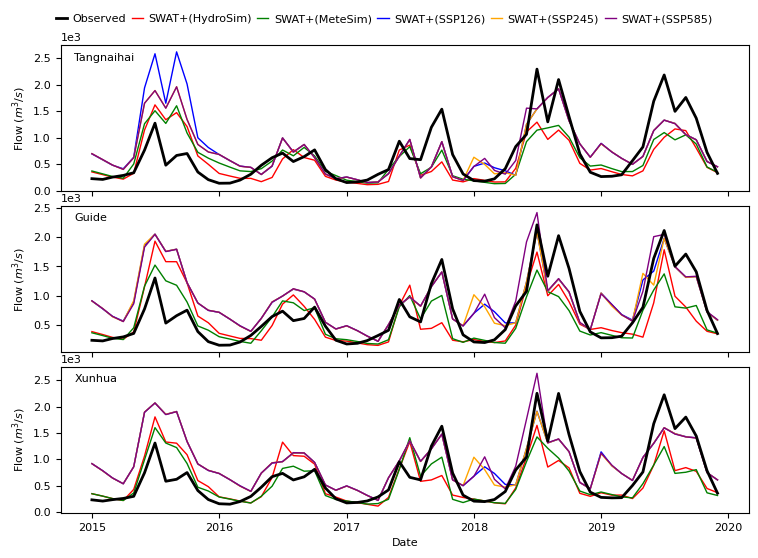

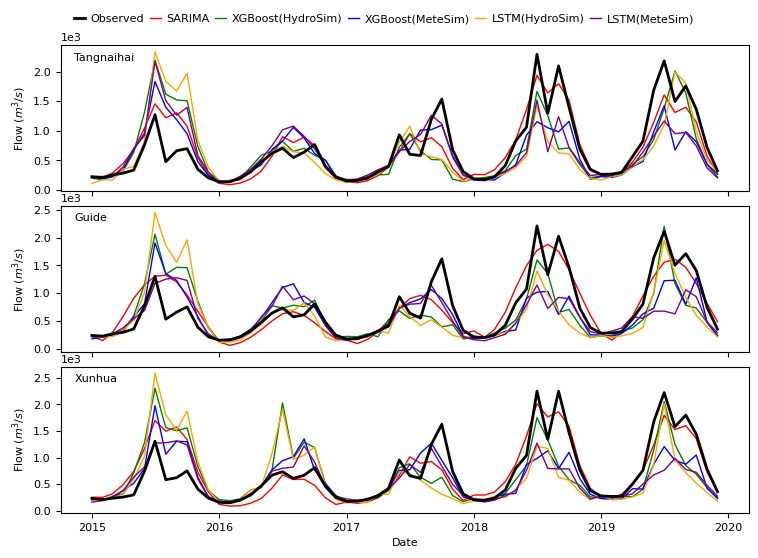

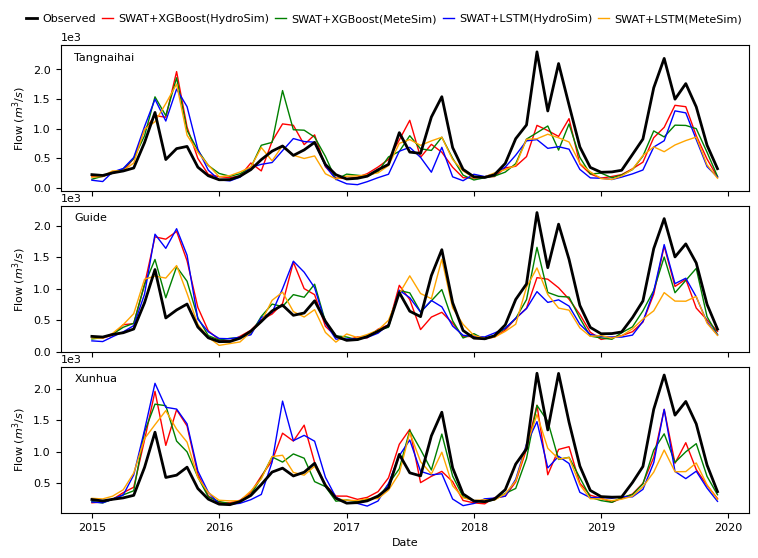

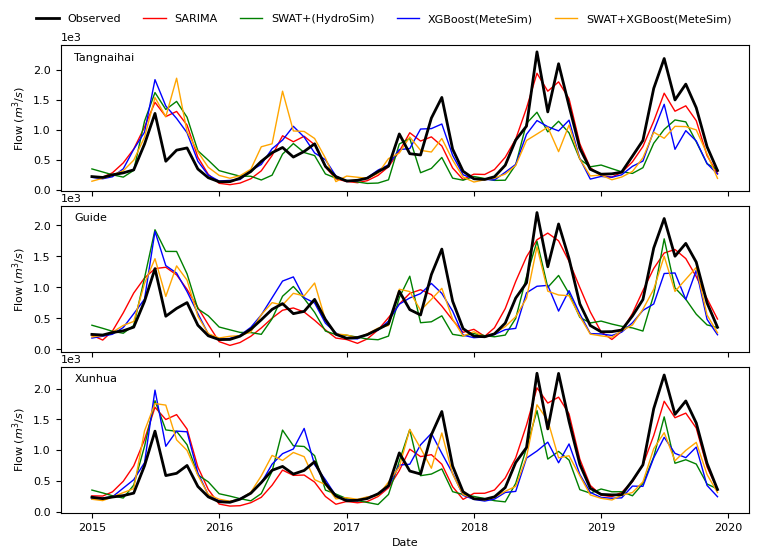

In [174]:

model_results = {}
model_errors = {}
metrics_dict = {}
nnse_years_metrics_dict = {}
znrmse_years_metrics_dict = {}
ppts_years_metrics_dict = {}
lpts_years_metrics_dict = {}

for i, hydro_station in enumerate(hydro_stations):
    model_results_df = pd.DataFrame(index=index)
    model_errors_df = pd.DataFrame(index=index)
    obs = pd.read_csv(f'../data/{hydro_station.lower()}_natural_monthly_flow.csv',index_col=['date'],parse_dates=['date'])
    obs_his = obs.copy()
    obs = obs.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31','flow(m^3/s)']
    obs.index = index

    

    model_results_df['obs'] = obs.values

    # historical monthly mean flow
    obs_his = obs_his.loc[:f'{pred_years[0]-1}-12-31']
    obs_his_monthly_mean = obs_his.groupby(obs_his.index.month)['flow(m^3/s)'].mean()
    # Create a new DataFrame with monthly average flow for 2015
    df_monthly_avg = pd.DataFrame(index=index)
    # Replicate the monthly average flow for years 2015-2019
    for year in range(pred_years[0],pred_years[-1]+1):
        for month in range(1,13):   
            df_monthly_avg.loc[f'{year}-{month}-01','flow(m^3/s)'] = obs_his_monthly_mean[month]
    df_monthly_avg = df_monthly_avg.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31','flow(m^3/s)']
    df_monthly_avg_error = df_monthly_avg - obs
    model_results_df['MonthlyMeanFlow'] = df_monthly_avg.values
    model_errors_df['MonthlyMeanFlow'] = df_monthly_avg_error.values

    
    # load SARIMA forecasts: date,flow(m^3/s)
    sarima = pd.read_csv(f'../result/ARIMAPredData/seasonal_decompose_multiplicative_arima_pred_{hydro_station.lower()}_{pred_years[0]}_{pred_years[-1]}.csv',index_col=['date'],parse_dates=['date'])
    sarima = sarima.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31','flow(m^3/s)']
    sarima.name = 'SARIMA'
    sarima.index = index
    sarima_error = sarima - obs
    model_results_df['SARIMA'] = sarima.values
    model_errors_df['SARIMA'] = sarima_error.values

    # load hydrosim-based HCF-SWAT+ forecasts: date,obs,pred
    hydrosim_hcf_swat = pd.read_csv(f'../result/SWATPlusPredUsingHydroSimYearData/{hydro_station}_SWATPlus_pred_obs_{pred_years[0]}_{pred_years[-1]}.csv',index_col=['date'],parse_dates=['date'])
    hydrosim_hcf_swat = hydrosim_hcf_swat.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31','pred']
    hydrosim_hcf_swat.name = 'SWAT+(HydroSim)'
    hydrosim_hcf_swat.index = index
    hydrosim_hcf_swat_error = hydrosim_hcf_swat - obs
    model_results_df['SWAT+(HydroSim)'] = hydrosim_hcf_swat.values
    model_errors_df['SWAT+(HydroSim)'] = hydrosim_hcf_swat_error.values
    # load metestations-based HCF-SWAT+ forecasts: date,obs,pred
    metestations_hcf_swat = pd.read_csv(f'../result/SWATPlusPredUsingMeteSimYearData/{hydro_station}_SWATPlus_pred_obs_{pred_years[0]}_{pred_years[-1]}.csv',index_col=['date'],parse_dates=['date'])
    metestations_hcf_swat = metestations_hcf_swat.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31','pred']
    metestations_hcf_swat.name = 'SWAT+(MeteSim)'
    metestations_hcf_swat.index = index
    metestations_hcf_swat_error = metestations_hcf_swat - obs
    model_results_df['SWAT+(MeteSim)'] = metestations_hcf_swat.values
    model_errors_df['SWAT+(MeteSim)'] = metestations_hcf_swat_error.values
    # load hydrosim-based HCF-XGBoost forecasts: date,obs,pred
    hydrosim_hcf_xgboost = pd.read_csv(f'../result/XGboostPredResult/{hydro_station}/InputOutputSamples_hydrosimyr/XGBoost_pred_{pred_years[0]}_{pred_years[-1]}.csv',index_col=['date'],parse_dates=['date'])
    hydrosim_hcf_xgboost = hydrosim_hcf_xgboost.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31','pred']
    hydrosim_hcf_xgboost.name = 'XGBoost(HydroSim)'
    hydrosim_hcf_xgboost.index = index
    hydrosim_hcf_xgboost_error = hydrosim_hcf_xgboost - obs
    model_results_df['XGBoost(HydroSim)'] = hydrosim_hcf_xgboost.values
    model_errors_df['XGBoost(HydroSim)'] = hydrosim_hcf_xgboost_error.values
    # load metestations-based HCF-XGBoost forecasts: date,obs,pred
    metestations_hcf_xgboost = pd.read_csv(f'../result/XGboostPredResult/{hydro_station}/InputOutputSamples_metesimyr/XGBoost_pred_{pred_years[0]}_{pred_years[-1]}.csv',index_col=['date'],parse_dates=['date'])
    metestations_hcf_xgboost = metestations_hcf_xgboost.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31','pred']
    metestations_hcf_xgboost.name = 'XGBoost(MeteSim)'
    metestations_hcf_xgboost.index = index
    metestations_hcf_xgboost_error = metestations_hcf_xgboost - obs
    model_results_df['XGBoost(MeteSim)'] = metestations_hcf_xgboost.values
    model_errors_df['XGBoost(MeteSim)'] = metestations_hcf_xgboost_error.values
    # load hydrosim-based HCF-LSTM forecasts: date,obs,pred
    hydrosim_hcf_lstm = pd.read_csv(f'../result/LSTMRegressorData/{hydro_station}/InputOutputSamples_hydrosimyr/vif_lstm_pred_{pred_years[0]}_{pred_years[-1]}.csv',index_col=['date'],parse_dates=['date'])
    hydrosim_hcf_lstm = hydrosim_hcf_lstm.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31','pred']
    hydrosim_hcf_lstm.name = 'LSTM(HydroSim)'
    hydrosim_hcf_lstm.index = index
    hydrosim_hcf_lstm_error = hydrosim_hcf_lstm - obs
    model_results_df['LSTM(HydroSim)'] = hydrosim_hcf_lstm.values
    model_errors_df['LSTM(HydroSim)'] = hydrosim_hcf_lstm_error.values
    # load metestations-based HCF-LSTM forecasts: date,obs,pred
    metestations_hcf_lstm = pd.read_csv(f'../result/LSTMRegressorData/{hydro_station}/InputOutputSamples_metesimyr/vif_lstm_pred_{pred_years[0]}_{pred_years[-1]}.csv',index_col=['date'],parse_dates=['date'])
    metestations_hcf_lstm = metestations_hcf_lstm.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31','pred']
    metestations_hcf_lstm.name = 'LSTM(MeteSim)'
    metestations_hcf_lstm.index = index
    metestations_hcf_lstm_error = metestations_hcf_lstm - obs
    model_results_df['LSTM(MeteSim)'] = metestations_hcf_lstm.values
    model_errors_df['LSTM(MeteSim)'] = metestations_hcf_lstm_error.values

    # load hydrosim-based HCF-SWAT+XGBoost forecasts: date,obs,pred
    hydrosim_hcf_swat_xgboost = pd.read_csv(f'../result/XGboostPredResult/{hydro_station}/InputOutputSamples_hydrosimyr_swatpsim/XGBoost_pred_{pred_years[0]}_{pred_years[-1]}.csv',index_col=['date'],parse_dates=['date'])
    hydrosim_hcf_swat_xgboost = hydrosim_hcf_swat_xgboost.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31','pred']
    hydrosim_hcf_swat_xgboost.name = 'SWAT+XGBoost(HydroSim)'
    hydrosim_hcf_swat_xgboost.index = index
    hydrosim_hcf_swat_xgboost_error = hydrosim_hcf_swat_xgboost - obs
    model_results_df['SWAT+XGBoost(HydroSim)'] = hydrosim_hcf_swat_xgboost.values
    model_errors_df['SWAT+XGBoost(HydroSim)'] = hydrosim_hcf_swat_xgboost_error.values
    # load metestations-based HCF-SWAT+XGBoost forecasts: date,obs,pred
    metestations_hcf_swat_xgboost = pd.read_csv(f'../result/XGboostPredResult/{hydro_station}/InputOutputSamples_metesimyr_swatpsim/XGBoost_pred_{pred_years[0]}_{pred_years[-1]}.csv',index_col=['date'],parse_dates=['date'])
    metestations_hcf_swat_xgboost = metestations_hcf_swat_xgboost.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31','pred']
    metestations_hcf_swat_xgboost.name = 'SWAT+XGBoost(MeteSim)'
    metestations_hcf_swat_xgboost.index = index
    metestations_hcf_swat_xgboost_error = metestations_hcf_swat_xgboost - obs
    model_results_df['SWAT+XGBoost(MeteSim)'] = metestations_hcf_swat_xgboost.values
    model_errors_df['SWAT+XGBoost(MeteSim)'] = metestations_hcf_swat_xgboost_error.values
    # load hydrosim-based HCF-SWAT+LSTM forecasts: date,obs,pred
    hydrosim_hcf_swat_lstm = pd.read_csv(f'../result/LSTMRegressorData/{hydro_station}/InputOutputSamples_hydrosimyr_swatpsim/vif_lstm_pred_{pred_years[0]}_{pred_years[-1]}.csv',index_col=['date'],parse_dates=['date'])
    hydrosim_hcf_swat_lstm = hydrosim_hcf_swat_lstm.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31','pred']
    hydrosim_hcf_swat_lstm.name = 'SWAT+LSTM(HydroSim)'
    hydrosim_hcf_swat_lstm.index = index
    hydrosim_hcf_swat_lstm_error = hydrosim_hcf_swat_lstm - obs
    model_results_df['SWAT+LSTM(HydroSim)'] = hydrosim_hcf_swat_lstm.values
    model_errors_df['SWAT+LSTM(HydroSim)'] = hydrosim_hcf_swat_lstm_error.values
    # load metestations-based HCF-SWAT+LSTM forecasts: date,obs,pred
    metestations_hcf_swat_lstm = pd.read_csv(f'../result/LSTMRegressorData/{hydro_station}/InputOutputSamples_metesimyr_swatpsim/vif_lstm_pred_{pred_years[0]}_{pred_years[-1]}.csv',index_col=['date'],parse_dates=['date'])
    metestations_hcf_swat_lstm = metestations_hcf_swat_lstm.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31','pred']
    metestations_hcf_swat_lstm.name = 'SWAT+LSTM(MeteSim)'
    metestations_hcf_swat_lstm.index = index
    metestations_hcf_swat_lstm_error = metestations_hcf_swat_lstm - obs
    model_results_df['SWAT+LSTM(MeteSim)'] = metestations_hcf_swat_lstm.values
    model_errors_df['SWAT+LSTM(MeteSim)'] = metestations_hcf_swat_lstm_error.values
    # load GCMCF-SWAT+ ssp126 forecasts: date,obs,pred
    gcmcf_swat_ssp126 = pd.read_csv(f'../result/SWATPlusPredUsingClimatePatternData/{hydro_station}_SWATPlus_pred_obs_ssp126_{pred_years[0]}_{pred_years[-1]}_corrected_using_historical_mean_std.csv',index_col=['date'],parse_dates=['date'])
    gcmcf_swat_ssp126 = gcmcf_swat_ssp126.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31','corrected_pred']
    gcmcf_swat_ssp126.name = 'SWAT+(SSP126)'
    gcmcf_swat_ssp126.index = index
    gcmcf_swat_ssp126_error = gcmcf_swat_ssp126 - obs
    model_results_df['SWAT+(SSP126)'] = gcmcf_swat_ssp126.values
    model_errors_df['SWAT+(SSP126)'] = gcmcf_swat_ssp126_error.values
    # load GCMCF-SWAT+ ssp245 forecasts: date,obs,pred
    gcmcf_swat_ssp245 = pd.read_csv(f'../result/SWATPlusPredUsingClimatePatternData/{hydro_station}_SWATPlus_pred_obs_ssp245_{pred_years[0]}_{pred_years[-1]}_corrected_using_historical_mean_std.csv',index_col=['date'],parse_dates=['date'])
    gcmcf_swat_ssp245 = gcmcf_swat_ssp245.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31','corrected_pred']
    gcmcf_swat_ssp245.name = 'SWAT+(SSP245)'
    gcmcf_swat_ssp245.index = index
    gcmcf_swat_ssp245_error = gcmcf_swat_ssp245 - obs
    model_results_df['SWAT+(SSP245)'] = gcmcf_swat_ssp245.values
    model_errors_df['SWAT+(SSP245)'] = gcmcf_swat_ssp245_error.values

    # load GCMCF-SWAT+ ssp585 forecasts: date,obs,pred
    gcmcf_swat_ssp585 = pd.read_csv(f'../result/SWATPlusPredUsingClimatePatternData/{hydro_station}_SWATPlus_pred_obs_ssp585_{pred_years[0]}_{pred_years[-1]}_corrected_using_historical_mean_std.csv',index_col=['date'],parse_dates=['date'])
    gcmcf_swat_ssp585 = gcmcf_swat_ssp585.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31','corrected_pred']
    gcmcf_swat_ssp585.name = 'SWAT+(SSP585)'
    gcmcf_swat_ssp585.index = index
    gcmcf_swat_ssp585_error = gcmcf_swat_ssp585 - obs
    model_results_df['SWAT+(SSP585)'] = gcmcf_swat_ssp585.values
    model_errors_df['SWAT+(SSP585)'] = gcmcf_swat_ssp585_error.values

    model_results[hydro_station] = model_results_df
    model_errors[hydro_station] = model_errors_df

    # calculate performance metrics
    monthly_mean_sample_nnse = NNSE(y_pred=model_results_df['MonthlyMeanFlow'],y_true=obs)
    monthly_mean_sample_znrmse = ZNRMSE(y_pred=model_results_df['MonthlyMeanFlow'],y_true=obs)
    monthly_mean_sample_ppts = PPTS(y_pred=model_results_df['MonthlyMeanFlow'],y_true=obs)
    monthly_mean_sample_lpts = LPTS(y_pred=model_results_df['MonthlyMeanFlow'],y_true=obs)

    sarima_nnse = NNSE(y_pred=sarima,y_true=obs)
    sarima_znrmse = ZNRMSE(y_pred=sarima,y_true=obs)
    sarima_ppts = PPTS(y_pred=sarima,y_true=obs)
    sarima_lpts = LPTS(y_pred=sarima,y_true=obs)

    hydrosim_hcf_swat_nnse = NNSE(y_pred=hydrosim_hcf_swat,y_true=obs)
    hydrosim_hcf_swat_znrmse = ZNRMSE(y_pred=hydrosim_hcf_swat,y_true=obs)
    hydrosim_hcf_swat_ppts = PPTS(y_pred=hydrosim_hcf_swat,y_true=obs)
    hydrosim_hcf_swat_lpts = LPTS(y_pred=hydrosim_hcf_swat,y_true=obs)

    metestations_hcf_swat_nnse = NNSE(y_pred=metestations_hcf_swat,y_true=obs)
    metestations_hcf_swat_znrmse = ZNRMSE(y_pred=metestations_hcf_swat,y_true=obs)
    metestations_hcf_swat_ppts = PPTS(y_pred=metestations_hcf_swat,y_true=obs)
    metestations_hcf_swat_lpts = LPTS(y_pred=metestations_hcf_swat,y_true=obs)

    hydrosim_hcf_xgboost_nnse = NNSE(y_pred=hydrosim_hcf_xgboost,y_true=obs)
    hydrosim_hcf_xgboost_znrmse = ZNRMSE(y_pred=hydrosim_hcf_xgboost,y_true=obs)
    hydrosim_hcf_xgboost_ppts = PPTS(y_pred=hydrosim_hcf_xgboost,y_true=obs)
    hydrosim_hcf_xgboost_lpts = LPTS(y_pred=hydrosim_hcf_xgboost,y_true=obs)

    metestations_hcf_xgboost_nnse = NNSE(y_pred=metestations_hcf_xgboost,y_true=obs)
    metestations_hcf_xgboost_znrmse = ZNRMSE(y_pred=metestations_hcf_xgboost,y_true=obs)
    metestations_hcf_xgboost_ppts = PPTS(y_pred=metestations_hcf_xgboost,y_true=obs)
    metestations_hcf_xgboost_lpts = LPTS(y_pred=metestations_hcf_xgboost,y_true=obs)

    hydrosim_hcf_lstm_nnse = NNSE(y_pred=hydrosim_hcf_lstm,y_true=obs)
    hydrosim_hcf_lstm_znrmse = ZNRMSE(y_pred=hydrosim_hcf_lstm,y_true=obs)
    hydrosim_hcf_lstm_ppts = PPTS(y_pred=hydrosim_hcf_lstm,y_true=obs)
    hydrosim_hcf_lstm_lpts = LPTS(y_pred=hydrosim_hcf_lstm,y_true=obs)

    metestations_hcf_lstm_nnse = NNSE(y_pred=metestations_hcf_lstm,y_true=obs)
    metestations_hcf_lstm_znrmse = ZNRMSE(y_pred=metestations_hcf_lstm,y_true=obs)
    metestations_hcf_lstm_ppts = PPTS(y_pred=metestations_hcf_lstm,y_true=obs)
    metestations_hcf_lstm_lpts = LPTS(y_pred=metestations_hcf_lstm,y_true=obs)

    hydrosim_hcf_swat_xgboost_nnse = NNSE(y_pred=hydrosim_hcf_swat_xgboost,y_true=obs)
    hydrosim_hcf_swat_xgboost_znrmse = ZNRMSE(y_pred=hydrosim_hcf_swat_xgboost,y_true=obs)
    hydrosim_hcf_swat_xgboost_ppts = PPTS(y_pred=hydrosim_hcf_swat_xgboost,y_true=obs)
    hydrosim_hcf_swat_xgboost_lpts = LPTS(y_pred=hydrosim_hcf_swat_xgboost,y_true=obs)

    metestations_hcf_swat_xgboost_nnse = NNSE(y_pred=metestations_hcf_swat_xgboost,y_true=obs)
    metestations_hcf_swat_xgboost_znrmse = ZNRMSE(y_pred=metestations_hcf_swat_xgboost,y_true=obs)
    metestations_hcf_swat_xgboost_ppts = PPTS(y_pred=metestations_hcf_swat_xgboost,y_true=obs)
    metestations_hcf_swat_xgboost_lpts = LPTS(y_pred=metestations_hcf_swat_xgboost,y_true=obs)

    hydrosim_hcf_swat_lstm_nnse = NNSE(y_pred=hydrosim_hcf_swat_lstm,y_true=obs)
    hydrosim_hcf_swat_lstm_znrmse = ZNRMSE(y_pred=hydrosim_hcf_swat_lstm,y_true=obs)
    hydrosim_hcf_swat_lstm_ppts = PPTS(y_pred=hydrosim_hcf_swat_lstm,y_true=obs)
    hydrosim_hcf_swat_lstm_lpts = LPTS(y_pred=hydrosim_hcf_swat_lstm,y_true=obs)

    metestations_hcf_swat_lstm_nnse = NNSE(y_pred=metestations_hcf_swat_lstm,y_true=obs)
    metestations_hcf_swat_lstm_znrmse = ZNRMSE(y_pred=metestations_hcf_swat_lstm,y_true=obs)
    metestations_hcf_swat_lstm_ppts = PPTS(y_pred=metestations_hcf_swat_lstm,y_true=obs)
    metestations_hcf_swat_lstm_lpts = LPTS(y_pred=metestations_hcf_swat_lstm,y_true=obs)

    gcmcf_swat_ssp126_nnse = NNSE(y_pred=gcmcf_swat_ssp126,y_true=obs)
    gcmcf_swat_ssp126_znrmse = ZNRMSE(y_pred=gcmcf_swat_ssp126,y_true=obs)
    gcmcf_swat_ssp126_ppts = PPTS(y_pred=gcmcf_swat_ssp126,y_true=obs)
    gcmcf_swat_ssp126_lpts = LPTS(y_pred=gcmcf_swat_ssp126,y_true=obs)

    gcmcf_swat_ssp245_nnse = NNSE(y_pred=gcmcf_swat_ssp245,y_true=obs)
    gcmcf_swat_ssp245_znrmse = ZNRMSE(y_pred=gcmcf_swat_ssp245,y_true=obs)
    gcmcf_swat_ssp245_ppts = PPTS(y_pred=gcmcf_swat_ssp245,y_true=obs)
    gcmcf_swat_ssp245_lpts = LPTS(y_pred=gcmcf_swat_ssp245,y_true=obs)

    gcmcf_swat_ssp585_nnse = NNSE(y_pred=gcmcf_swat_ssp585,y_true=obs)
    gcmcf_swat_ssp585_znrmse = ZNRMSE(y_pred=gcmcf_swat_ssp585,y_true=obs)
    gcmcf_swat_ssp585_ppts = PPTS(y_pred=gcmcf_swat_ssp585,y_true=obs)
    gcmcf_swat_ssp585_lpts = LPTS(y_pred=gcmcf_swat_ssp585,y_true=obs)

    model_performance = pd.DataFrame({
        'NNSE': [
            sarima_nnse, 
            hydrosim_hcf_swat_nnse, metestations_hcf_swat_nnse, gcmcf_swat_ssp126_nnse, gcmcf_swat_ssp245_nnse, gcmcf_swat_ssp585_nnse,
            hydrosim_hcf_xgboost_nnse, metestations_hcf_xgboost_nnse, hydrosim_hcf_lstm_nnse, metestations_hcf_lstm_nnse, 
            hydrosim_hcf_swat_xgboost_nnse, metestations_hcf_swat_xgboost_nnse, hydrosim_hcf_swat_lstm_nnse, metestations_hcf_swat_lstm_nnse, 
            
        ],
        'NRMSE': [
            sarima_znrmse, 
            hydrosim_hcf_swat_znrmse, metestations_hcf_swat_znrmse,gcmcf_swat_ssp126_znrmse, gcmcf_swat_ssp245_znrmse, gcmcf_swat_ssp585_znrmse,
            hydrosim_hcf_xgboost_znrmse, metestations_hcf_xgboost_znrmse, hydrosim_hcf_lstm_znrmse, metestations_hcf_lstm_znrmse, 
            hydrosim_hcf_swat_xgboost_znrmse, metestations_hcf_swat_xgboost_znrmse, hydrosim_hcf_swat_lstm_znrmse, metestations_hcf_swat_lstm_znrmse, 
        ],
        'PPTS': [
            sarima_ppts, 
            hydrosim_hcf_swat_ppts, metestations_hcf_swat_ppts, gcmcf_swat_ssp126_ppts, gcmcf_swat_ssp245_ppts, gcmcf_swat_ssp585_ppts,
            hydrosim_hcf_xgboost_ppts, metestations_hcf_xgboost_ppts, hydrosim_hcf_lstm_ppts, metestations_hcf_lstm_ppts, 
            hydrosim_hcf_swat_xgboost_ppts, metestations_hcf_swat_xgboost_ppts, hydrosim_hcf_swat_lstm_ppts, metestations_hcf_swat_lstm_ppts, 
        ],
        'LPTS': [
            sarima_lpts, 
            hydrosim_hcf_swat_lpts, metestations_hcf_swat_lpts, gcmcf_swat_ssp126_lpts, gcmcf_swat_ssp245_lpts, gcmcf_swat_ssp585_lpts,
            hydrosim_hcf_xgboost_lpts, metestations_hcf_xgboost_lpts, hydrosim_hcf_lstm_lpts, metestations_hcf_lstm_lpts, 
            hydrosim_hcf_swat_xgboost_lpts, metestations_hcf_swat_xgboost_lpts, hydrosim_hcf_swat_lstm_lpts, metestations_hcf_swat_lstm_lpts, 
        ]
    })

    model_performance.index = models
    model_performance.index.name = 'Model'
    metrics_dict[hydro_station] = model_performance

    model_performance.to_csv(f'../result/ModelEvaluationMetrics/MultiModelsForecastsPerformance_{hydro_station}.csv')
    nnse_year_performance = pd.DataFrame(index=pred_years,columns=models)
    nnse_year_performance.index.name = 'Year'
    znrmse_year_performance = pd.DataFrame(index=pred_years,columns=models)
    znrmse_year_performance.index.name = 'Year'
    ppts_year_performance = pd.DataFrame(index=pred_years,columns=models)
    ppts_year_performance.index.name = 'Year'
    lpts_year_performance = pd.DataFrame(index=pred_years,columns=models)
    lpts_year_performance.index.name = 'Year'
    for pred_year in pred_years:
        sarima_year_nnse = NNSE(y_pred=sarima.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        sarima_year_znrmse = ZNRMSE(y_pred=sarima.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        sarima_year_ppts = PPTS(y_pred=sarima.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        sarima_year_lpts = LPTS(y_pred=sarima.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])

        hydrosim_hcf_swat_year_nnse = NNSE(y_pred=hydrosim_hcf_swat.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        hydrosim_hcf_swat_year_znrmse = ZNRMSE(y_pred=hydrosim_hcf_swat.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        hydrosim_hcf_swat_year_ppts = PPTS(y_pred=hydrosim_hcf_swat.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        hydrosim_hcf_swat_year_lpts = LPTS(y_pred=hydrosim_hcf_swat.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])

        metestations_hcf_swat_year_nnse = NNSE(y_pred=metestations_hcf_swat.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        metestations_hcf_swat_year_znrmse = ZNRMSE(y_pred=metestations_hcf_swat.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        metestations_hcf_swat_year_ppts = PPTS(y_pred=metestations_hcf_swat.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        metestations_hcf_swat_year_lpts = LPTS(y_pred=metestations_hcf_swat.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])

        gcmcf_swat_ssp126_year_nnse = NNSE(y_pred=gcmcf_swat_ssp126.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        gcmcf_swat_ssp126_year_znrmse = ZNRMSE(y_pred=gcmcf_swat_ssp126.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        gcmcf_swat_ssp126_year_ppts = PPTS(y_pred=gcmcf_swat_ssp126.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        gcmcf_swat_ssp126_year_lpts = LPTS(y_pred=gcmcf_swat_ssp126.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])

        gcmcf_swat_ssp245_year_nnse = NNSE(y_pred=gcmcf_swat_ssp245.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        gcmcf_swat_ssp245_year_znrmse = ZNRMSE(y_pred=gcmcf_swat_ssp245.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        gcmcf_swat_ssp245_year_ppts = PPTS(y_pred=gcmcf_swat_ssp245.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        gcmcf_swat_ssp245_year_lpts = LPTS(y_pred=gcmcf_swat_ssp245.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])

        gcmcf_swat_ssp585_year_nnse = NNSE(y_pred=gcmcf_swat_ssp585.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        gcmcf_swat_ssp585_year_znrmse = ZNRMSE(y_pred=gcmcf_swat_ssp585.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        gcmcf_swat_ssp585_year_ppts = PPTS(y_pred=gcmcf_swat_ssp585.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        gcmcf_swat_ssp585_year_lpts = LPTS(y_pred=gcmcf_swat_ssp585.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])

        hydrosim_hcf_xgboost_year_nnse = NNSE(y_pred=hydrosim_hcf_xgboost.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        hydrosim_hcf_xgboost_year_znrmse = ZNRMSE(y_pred=hydrosim_hcf_xgboost.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        hydrosim_hcf_xgboost_year_ppts = PPTS(y_pred=hydrosim_hcf_xgboost.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        hydrosim_hcf_xgboost_year_lpts = LPTS(y_pred=hydrosim_hcf_xgboost.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])

        metestations_hcf_xgboost_year_nnse = NNSE(y_pred=metestations_hcf_xgboost.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        metestations_hcf_xgboost_year_znrmse = ZNRMSE(y_pred=metestations_hcf_xgboost.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        metestations_hcf_xgboost_year_ppts = PPTS(y_pred=metestations_hcf_xgboost.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        metestations_hcf_xgboost_year_lpts = LPTS(y_pred=metestations_hcf_xgboost.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])

        hydrosim_hcf_lstm_year_nnse = NNSE(y_pred=hydrosim_hcf_lstm.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        hydrosim_hcf_lstm_year_znrmse = ZNRMSE(y_pred=hydrosim_hcf_lstm.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        hydrosim_hcf_lstm_year_ppts = PPTS(y_pred=hydrosim_hcf_lstm.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        hydrosim_hcf_lstm_year_lpts = LPTS(y_pred=hydrosim_hcf_lstm.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])

        metestations_hcf_lstm_year_nnse = NNSE(y_pred=metestations_hcf_lstm.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        metestations_hcf_lstm_year_znrmse = ZNRMSE(y_pred=metestations_hcf_lstm.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        metestations_hcf_lstm_year_ppts = PPTS(y_pred=metestations_hcf_lstm.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        metestations_hcf_lstm_year_lpts = LPTS(y_pred=metestations_hcf_lstm.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])

        hydrosim_hcf_swat_xgboost_year_nnse = NNSE(y_pred=hydrosim_hcf_swat_xgboost.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        hydrosim_hcf_swat_xgboost_year_znrmse = ZNRMSE(y_pred=hydrosim_hcf_swat_xgboost.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        hydrosim_hcf_swat_xgboost_year_ppts = PPTS(y_pred=hydrosim_hcf_swat_xgboost.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        hydrosim_hcf_swat_xgboost_year_lpts = LPTS(y_pred=hydrosim_hcf_swat_xgboost.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])

        metestations_hcf_swat_xgboost_year_nnse = NNSE(y_pred=metestations_hcf_swat_xgboost.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        metestations_hcf_swat_xgboost_year_znrmse = ZNRMSE(y_pred=metestations_hcf_swat_xgboost.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        metestations_hcf_swat_xgboost_year_ppts = PPTS(y_pred=metestations_hcf_swat_xgboost.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        metestations_hcf_swat_xgboost_year_lpts = LPTS(y_pred=metestations_hcf_swat_xgboost.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])

        hydrosim_hcf_swat_lstm_year_nnse = NNSE(y_pred=hydrosim_hcf_swat_lstm.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        hydrosim_hcf_swat_lstm_year_znrmse = ZNRMSE(y_pred=hydrosim_hcf_swat_lstm.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        hydrosim_hcf_swat_lstm_year_ppts = PPTS(y_pred=hydrosim_hcf_swat_lstm.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        hydrosim_hcf_swat_lstm_year_lpts = LPTS(y_pred=hydrosim_hcf_swat_lstm.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])

        metestations_hcf_swat_lstm_year_nnse = NNSE(y_pred=metestations_hcf_swat_lstm.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        metestations_hcf_swat_lstm_year_znrmse = ZNRMSE(y_pred=metestations_hcf_swat_lstm.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        metestations_hcf_swat_lstm_year_ppts = PPTS(y_pred=metestations_hcf_swat_lstm.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])
        metestations_hcf_swat_lstm_year_lpts = LPTS(y_pred=metestations_hcf_swat_lstm.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'],y_true=obs.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'])

        
        nnse_year_performance.loc[pred_year] = [
            sarima_year_nnse, 
            hydrosim_hcf_swat_year_nnse, metestations_hcf_swat_year_nnse, gcmcf_swat_ssp126_year_nnse, gcmcf_swat_ssp245_year_nnse, gcmcf_swat_ssp585_year_nnse,
            hydrosim_hcf_xgboost_year_nnse, metestations_hcf_xgboost_year_nnse,hydrosim_hcf_lstm_year_nnse, metestations_hcf_lstm_year_nnse,
            hydrosim_hcf_swat_xgboost_year_nnse, metestations_hcf_swat_xgboost_year_nnse,
            hydrosim_hcf_swat_lstm_year_nnse, metestations_hcf_swat_lstm_year_nnse,]

        znrmse_year_performance.loc[pred_year] = [
            sarima_year_znrmse,
            hydrosim_hcf_swat_year_znrmse, metestations_hcf_swat_year_znrmse, gcmcf_swat_ssp126_year_znrmse, gcmcf_swat_ssp245_year_znrmse, gcmcf_swat_ssp585_year_znrmse,
            hydrosim_hcf_xgboost_year_znrmse, metestations_hcf_xgboost_year_znrmse, hydrosim_hcf_lstm_year_znrmse, metestations_hcf_lstm_year_znrmse,
            hydrosim_hcf_swat_xgboost_year_znrmse, metestations_hcf_swat_xgboost_year_znrmse,
            hydrosim_hcf_swat_lstm_year_znrmse, metestations_hcf_swat_lstm_year_znrmse,]

        ppts_year_performance.loc[pred_year] = [
            sarima_year_ppts,
            hydrosim_hcf_swat_year_ppts, metestations_hcf_swat_year_ppts, gcmcf_swat_ssp126_year_ppts, gcmcf_swat_ssp245_year_ppts, gcmcf_swat_ssp585_year_ppts,
            hydrosim_hcf_xgboost_year_ppts, metestations_hcf_xgboost_year_ppts, hydrosim_hcf_lstm_year_ppts, metestations_hcf_lstm_year_ppts,
            hydrosim_hcf_swat_xgboost_year_ppts, metestations_hcf_swat_xgboost_year_ppts,
            hydrosim_hcf_swat_lstm_year_ppts, metestations_hcf_swat_lstm_year_ppts,]

        lpts_year_performance.loc[pred_year] = [
            sarima_year_lpts,
            hydrosim_hcf_swat_year_lpts, metestations_hcf_swat_year_lpts, gcmcf_swat_ssp126_year_lpts, gcmcf_swat_ssp245_year_lpts, gcmcf_swat_ssp585_year_lpts,
            hydrosim_hcf_xgboost_year_lpts, metestations_hcf_xgboost_year_lpts, hydrosim_hcf_lstm_year_lpts, metestations_hcf_lstm_year_lpts,
            hydrosim_hcf_swat_xgboost_year_lpts, metestations_hcf_swat_xgboost_year_lpts,
            hydrosim_hcf_swat_lstm_year_lpts, metestations_hcf_swat_lstm_year_lpts,]

    nnse_years_metrics_dict[hydro_station] = nnse_year_performance
    znrmse_years_metrics_dict[hydro_station] = znrmse_year_performance
    ppts_years_metrics_dict[hydro_station] = ppts_year_performance
    lpts_years_metrics_dict[hydro_station] = lpts_year_performance
        


#---Do not delete comments below
colors = [
    'red',#"#FF0000",
    'green',#"#008000",
    'blue',#"#0000FF",
    'orange',#"#FFA500",
    'purple',#"#800080",
    'brown',#"#A52A2A",
    'pink',#"#FFC0CB",
    'gray',#"#808080",
    'olive',#"#808000",
    'cyan',#"#00FFFF",
    'magenta',#"#FF00FF",
    'yellow',#"#FFFF00",
    'lime',#"#00FF00",
    'teal',#"#008080",
    # 'lavender',#"#E6E6FA",
]

# Group models
process_driven = ['SWAT+(HydroSim)', 'SWAT+(MeteSim)','SWAT+(SSP126)', 'SWAT+(SSP245)', 'SWAT+(SSP585)']
data_driven = ['SARIMA', 'XGBoost(HydroSim)', 'XGBoost(MeteSim)', 
               'LSTM(HydroSim)', 'LSTM(MeteSim)']
hybrid = ['SWAT+XGBoost(HydroSim)', 'SWAT+XGBoost(MeteSim)',
          'SWAT+LSTM(HydroSim)', 'SWAT+LSTM(MeteSim)']

model_groups = [process_driven, data_driven, hybrid]
group_names = ['Process-driven Models', 'Data-driven Models', 
               'Hybrid Models']
group_ncols = [6, 6, 6]
for group_idx, model_group in enumerate(model_groups):
    fig, axes = plt.subplots(3, 1, figsize=(7.48, 5.5), sharex=True)
    
    for i, hydro_station in enumerate(hydro_stations):
        model_results_df = model_results[hydro_station]
        ax = axes[i]
        
        # Plot observed data
        ax.plot(model_results_df.index, model_results_df['obs'], 
                label='Observed', linewidth=2, color='black', zorder=20)
        
        # Plot models in current group
        for model, color in zip(model_group, colors[:len(model_group)]):
            ax.plot(model_results_df.index, model_results_df[model],
                    label=model, color=color, linewidth=1, linestyle='-')
            
        if i == 0:
            ax.legend(bbox_to_anchor=(0.47, 1.28), loc='upper center',
                     ncol=group_ncols[group_idx], frameon=False, fontsize=8,
                     handlelength=1, handletextpad=0.5,
                     columnspacing=0.5)
            
        ax.text(0.02, 0.95, hydro_station, transform=ax.transAxes,
                fontsize=8, va='top')
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax.set_ylabel('Flow ($m^3/s$)')
        
        if i == 2:
            ax.set_xlabel('Date')
    
    # plt.suptitle(group_names[group_idx], y=0.95)
    plt.subplots_adjust(left=0.07, right=0.99, bottom=0.07,
                       top=0.92, hspace=0.1, wspace=0.02)
    plt.savefig(f'../figs/MultiModelsForecasts_{group_names[group_idx].replace(" ","_")}.png',
                dpi=300)
    plt.savefig(f'../figs/MultiModelsForecasts_{group_names[group_idx].replace(" ","_")}.tif',
                format='tif', dpi=500)
    plt.show()
#----Don not delete comments above

selected_models = ['SARIMA','SWAT+(HydroSim)', 'XGBoost(MeteSim)','SWAT+XGBoost(MeteSim)']
colors_for_selected_models = ['red', 'blue', 'cyan']
fig, axes = plt.subplots(3, 1, figsize=(7.48, 5.5), sharex=True)

for i, hydro_station in enumerate(hydro_stations):
    model_results_df = model_results[hydro_station]
    ax = axes[i]
    
    # Plot observed data
    ax.plot(model_results_df.index, model_results_df['obs'], 
            label='Observed', linewidth=2, color='black', zorder=20)
    
    # Plot selected models
    for model, color in zip(selected_models, colors[:len(selected_models)]):
        ax.plot(model_results_df.index, model_results_df[model],
                label=model, color=color, linewidth=1, linestyle='-')
        
    if i == 0:
        ax.legend(bbox_to_anchor=(0.47, 1.28), loc='upper center',
                 ncol=6, frameon=False, fontsize=8,
                #  handlelength=1, handletextpad=0.5
                )
        
    ax.text(0.02, 0.95, hydro_station, transform=ax.transAxes,
            fontsize=8, va='top')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_ylabel('Flow ($m^3/s$)')
    
    if i == 2:
        ax.set_xlabel('Date')

plt.subplots_adjust(left=0.07, right=0.99, bottom=0.07,
                   top=0.92, hspace=0.1, wspace=0.02)
plt.savefig(f'../figs/MultiModelsForecasts_Selected_Models.png',
            dpi=300)
plt.savefig(f'../figs/MultiModelsForecasts_Selected_Models.tif',
            format='tif', dpi=500)
plt.show()



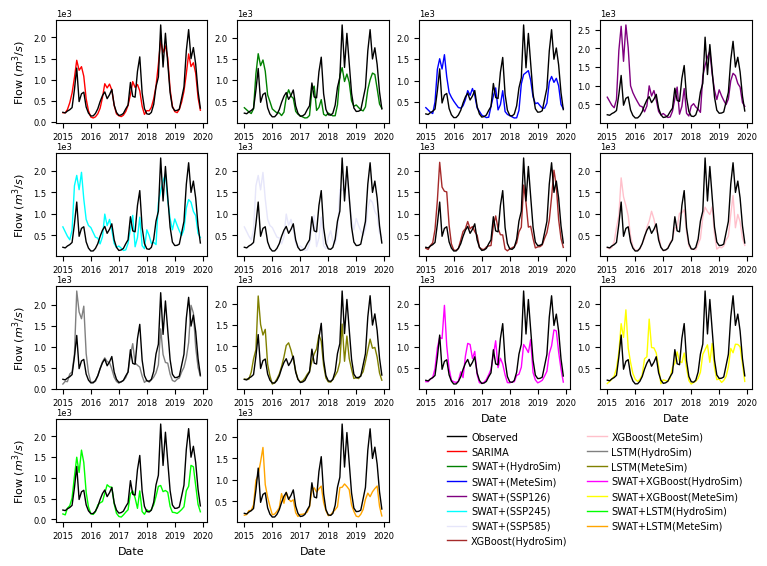

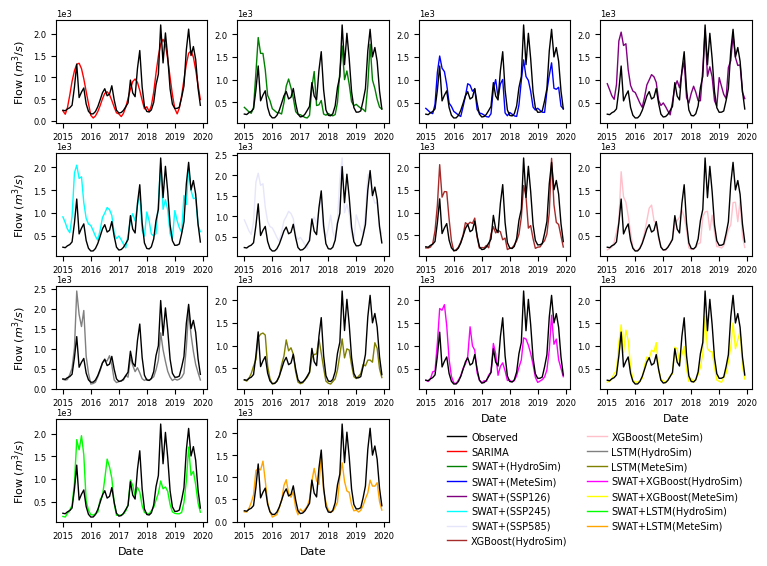

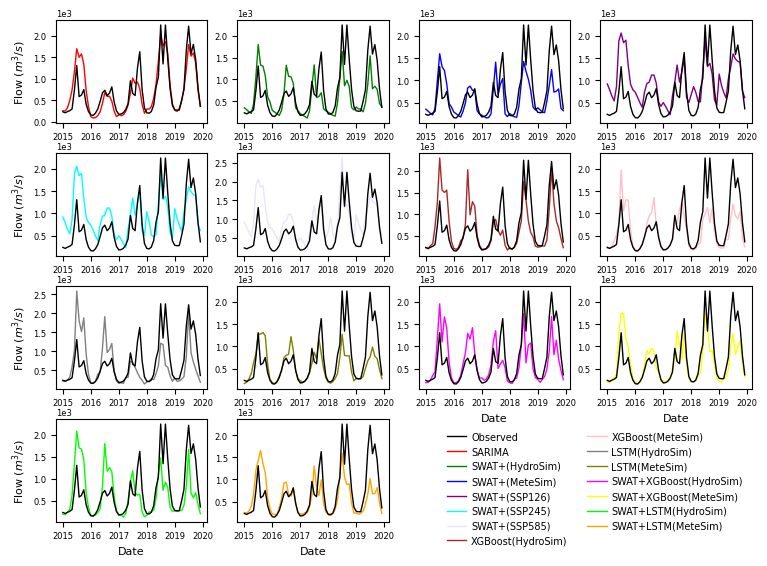

In [161]:
colors = [
    'red',#"#FF0000",
    'green',#"#008000", 
    'blue',#"#0000FF",
    'purple',#"#800080",
    'cyan',#"#00FFFF",
    'lavender',#"#E6E6FA",
    'brown',#"#A52A2A",
    'pink',#"#FFC0CB",
    'gray',#"#808080",
    'olive',#"#808000",
    'magenta',#"#FF00FF",
    'yellow',#"#FFFF00",
    'lime',#"#00FF00",
    'orange',#"#FFA500",
    'teal',#"#008080",
]
for hydro_station in hydro_stations:
    fig, axes = plt.subplots(4, 4, figsize=(7.48, 5.48))
    axes = axes.flatten()
    
    model_results_df = model_results[hydro_station]
    
    # Plot each model in separate subplot
    for i, model in enumerate(models[:14]):  # First 14 subplots for models
        ax = axes[i]
        
        # Plot observed data
        ax.plot(model_results_df.index, model_results_df['obs'],
                label='Observed' if i == 0 else "", linewidth=1, color='black', zorder=20)
        
        # Plot model prediction
        ax.plot(model_results_df.index, model_results_df[model],
                label=model, linewidth=1, color=colors[i])
        
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax.tick_params(labelsize=6)
        # Set scientific notation font size
        ax.yaxis.get_offset_text().set_fontsize(6)
        
        if i >= 12 or (i == 10 or i == 11):  # Bottom row and last two plots get x labels
            ax.set_xlabel('Date', fontsize=8)
        if i % 4 == 0:  # Left column gets y labels
            ax.set_ylabel('Flow ($m^3/s$)', fontsize=8)
    
    # Use last two subplots for legend
    axes[14].remove()
    axes[15].remove()
    fig.legend(bbox_to_anchor=(0.99, 0.12), loc='center right',
              ncol=2, frameon=False, fontsize=7, handlelength=2, handletextpad=0.5,columnspacing=2)
    
    plt.subplots_adjust(left=0.06, right=0.99, bottom=0.06,
                       top=0.975, hspace=0.3, wspace=0.2)
    plt.savefig(f'../figs/MultiModelsForecasts_{hydro_station}_individual.png',
                dpi=300)
    plt.savefig(f'../figs/MultiModelsForecasts_{hydro_station}_individual.tif',
                format='tif', dpi=500)
    plt.show()

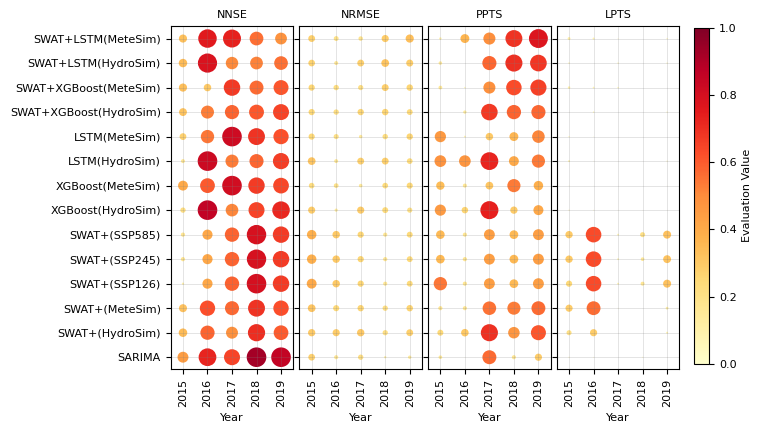

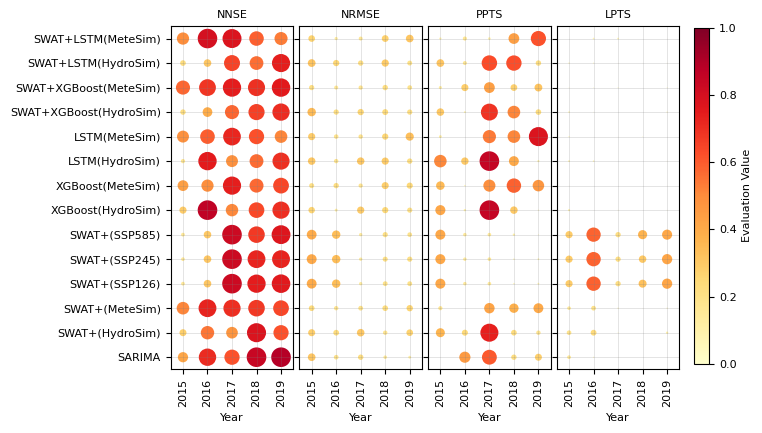

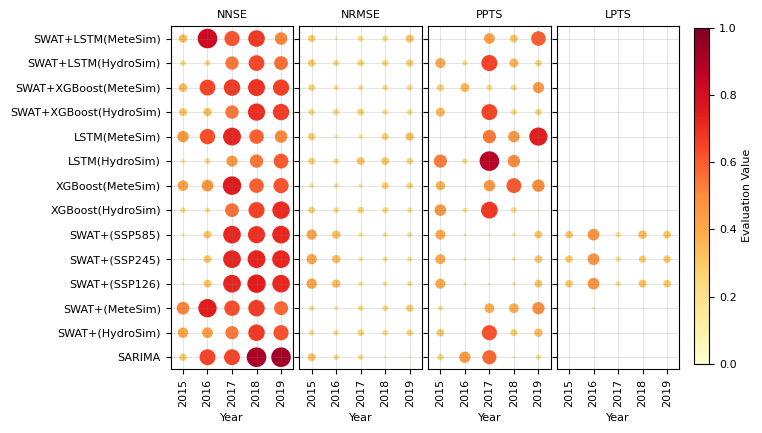

In [218]:
# Define metrics and their corresponding dictionaries
metrics = ['NNSE', 'NRMSE', 'PPTS', 'LPTS']
metric_dicts = [nnse_years_metrics_dict, znrmse_years_metrics_dict, ppts_years_metrics_dict, lpts_years_metrics_dict]

# Create one common colorbar for all heatmaps
norm = plt.Normalize(vmin=0, vmax=1)  # Changed range to 0-1
cmap = 'YlOrRd'  # Changed to YlOrRd colormap for darker colors with higher values
fontsize = 8  # Define fontsize variable

for hydro_station in hydro_stations:
    # Create a 1x4 subplot layout
    fig, axes = plt.subplots(1, 4, figsize=(7.48, 4.20))
    axes = axes.flatten()
    
    for j, (metric, metric_dict) in enumerate(zip(metrics, metric_dicts)):
        ax = axes[j]
        
        # Get data for current station and metric
        data = metric_dict[hydro_station]
        # Convert data to float type
        data = data.astype(float)
        
        # Transpose data to have years as columns and models as rows
        data = data.T
        
        # Create circle plot instead of heatmap
        years = data.columns
        models = data.index
        
        # Create meshgrid for circle centers
        xx, yy = np.meshgrid(np.arange(len(years)), np.arange(len(models)))
        
        # Set aspect ratio to 1 to ensure circles are circular
        ax.set_aspect('equal')
        
        # Plot circles
        for i, year in enumerate(years):
            for k, model in enumerate(models):
                size = data.loc[model, year] * 1000  # Scale size based on value
                color = plt.cm.YlOrRd(norm(data.loc[model, year]))
                circle = plt.Circle((i, k), radius=min(0.4, size/2000),
                                  facecolor=color, edgecolor='none')
                ax.add_patch(circle)
            
        # Set plot limits and labels
        ax.set_xlim(-0.5, len(years) - 0.5)
        ax.set_ylim(-0.5, len(models) - 0.5)
        
        # Set ticks and labels
        ax.set_xticks(np.arange(len(years)))
        ax.set_yticks(np.arange(len(models)))
        ax.set_xticklabels(years, rotation=90, fontsize=fontsize)
        if j == 0:  # Only show y labels for first column
            ax.set_yticklabels(models, fontsize=fontsize)
        else:
            ax.set_yticklabels([])
            
        # Customize axis labels and ticks
        ax.set_xlabel('Year', fontsize=fontsize)
        ax.set_ylabel('')
        
        # Add metric name as title
        ax.set_title(metric, fontsize=fontsize)
        
        # Rotate y-axis labels
        if j == 0:
            plt.setp(ax.get_yticklabels(), rotation=0)
            
        # Add gridlines
        ax.grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

    # Add colorbar on the right with adjusted position
    # [left, bottom, width, height] - colorbar position and size parameters:
    # 0.92: distance from left edge (92% from left)
    # 0.2: distance from bottom edge (20% from bottom) 
    # 0.02: width of colorbar (2% of figure width)
    # 0.6: height of colorbar (60% of figure height)
    # Adjusting these values will move/resize the colorbar:
    # - Increase left (>0.92) to move right, decrease (<0.92) to move left
    # - Increase bottom (>0.2) to move up, decrease (<0.2) to move down
    # - Increase width (>0.02) for thicker bar, decrease (<0.02) for thinner
    # - Increase height (>0.6) for taller bar, decrease (<0.6) for shorter
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.8])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), 
                       cax=cbar_ax, orientation='vertical',
                       label='Evaluation Value')  # Added colorbar label
    cbar.ax.tick_params(labelsize=fontsize)  # Set colorbar tick font size
    cbar.ax.set_ylabel('Evaluation Value', fontsize=fontsize)  # Set colorbar label font size
    
    # Adjust layout
    plt.subplots_adjust(left=0.22, right=0.9, bottom=0.11, top=0.98, wspace=0.05)

    # Save figures
    plt.savefig(f'../figs/MultiModelsForecasts_Metrics_Heatmap_{hydro_station}.png', 
                dpi=300, bbox_inches='tight')
    plt.savefig(f'../figs/MultiModelsForecasts_Metrics_Heatmap_{hydro_station}.tif', 
                format='tif', dpi=500)
    plt.show()

        SARIMA SWAT+(HydroSim) SWAT+(MeteSim) SWAT+(SSP126) SWAT+(SSP245)  \
2015   0.44538        0.347558       0.327219      0.090774       0.17084   
2016  0.722846        0.580657       0.625274      0.412633      0.413156   
2017  0.652154        0.487844       0.573185      0.586016      0.585669   
2018  0.923232        0.702105       0.690338      0.797755      0.789125   
2019  0.853226        0.599929       0.628059      0.671177       0.67147   

     SWAT+(SSP585) XGBoost(HydroSim) XGBoost(MeteSim) LSTM(HydroSim)  \
2015      0.171261          0.216264         0.403116       0.160657   
2016      0.412034          0.858143         0.602668       0.826161   
2017      0.584886          0.515557         0.808777       0.531914   
2018      0.792858          0.652165         0.669078       0.574341   
2019      0.670321            0.7155         0.641197       0.661336   

     LSTM(MeteSim) SWAT+XGBoost(HydroSim) SWAT+XGBoost(MeteSim)  \
2015      0.276169               0.32

TypeError: Image data of dtype object cannot be converted to float

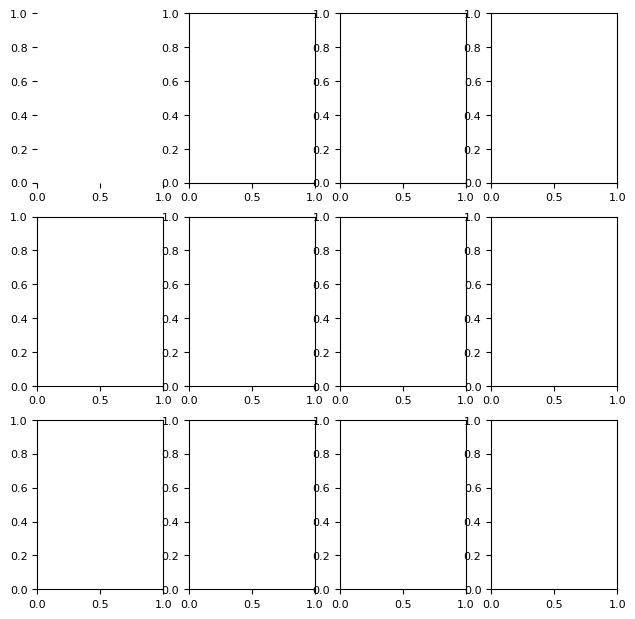

In [169]:
# Create a 3x4 subplot layout for the three stations and four metrics
fig, axes = plt.subplots(3, 4, figsize=(7.48, 7.48))

# Define metrics and their corresponding dictionaries
metrics = ['NNSE', 'NRMSE', 'PPTS', 'LPTS']
metric_dicts = [nnse_years_metrics_dict, znrmse_years_metrics_dict, ppts_years_metrics_dict, lpts_years_metrics_dict]

# Create one common colorbar for all heatmaps
norm = plt.Normalize(vmin=-1, vmax=1)  # Adjust vmin and vmax based on your data range
cmap = 'RdYlBu'  # You can change the colormap as needed

for i, hydro_station in enumerate(hydro_stations):
    for j, (metric, metric_dict) in enumerate(zip(metrics, metric_dicts)):
        ax = axes[i, j]
        
        # Get data for current station and metric
        data = metric_dict[hydro_station]
        print(data)
        
        # Create heatmap
        sns.heatmap(data, 
                   cmap=cmap,
                   norm=norm,
                   ax=ax,
                   cbar=True if (i == 0 and j == 3) else False,  # Only show colorbar for top-right plot
                   xticklabels=data.index,
                   yticklabels=data.columns if j == 0 else False,  # Only show model names for leftmost plots
                   cbar_kws={'label': ''} if (i == 0 and j == 3) else None)
        
        # Customize axis labels and ticks
        ax.set_xlabel('') if i < 2 else ax.set_xlabel('Year')
        ax.set_ylabel('') if j > 0 else ax.set_ylabel(hydro_station)
        
        # Rotate x-axis labels
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        # Rotate y-axis labels
        if j == 0:
            plt.setp(ax.get_yticklabels(), rotation=0)

# Adjust layout
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.1, top=0.95, wspace=0.05, hspace=0.05)

# Save figures
plt.savefig('../figs/MultiModelsForecasts_Metrics_Heatmap.png', dpi=300, bbox_inches='tight')
plt.savefig('../figs/MultiModelsForecasts_Metrics_Heatmap.tif', format='tif', dpi=500, bbox_inches='tight')
plt.show()

        SARIMA SWAT+(HydroSim) SWAT+(MeteSim) SWAT+(SSP126) SWAT+(SSP245)  \
2015   0.44538        0.347558       0.327219      0.090774       0.17084   
2016  0.722846        0.580657       0.625274      0.412633      0.413156   
2017  0.652154        0.487844       0.573185      0.586016      0.585669   
2018  0.923232        0.702105       0.690338      0.797755      0.789125   
2019  0.853226        0.599929       0.628059      0.671177       0.67147   

     SWAT+(SSP585) XGBoost(HydroSim) XGBoost(MeteSim) LSTM(HydroSim)  \
2015      0.171261          0.216264         0.403116       0.160657   
2016      0.412034          0.858143         0.602668       0.826161   
2017      0.584886          0.515557         0.808777       0.531914   
2018      0.792858          0.652165         0.669078       0.574341   
2019      0.670321            0.7155         0.641197       0.661336   

     LSTM(MeteSim) SWAT+XGBoost(HydroSim) SWAT+XGBoost(MeteSim)  \
2015      0.276169               0.32

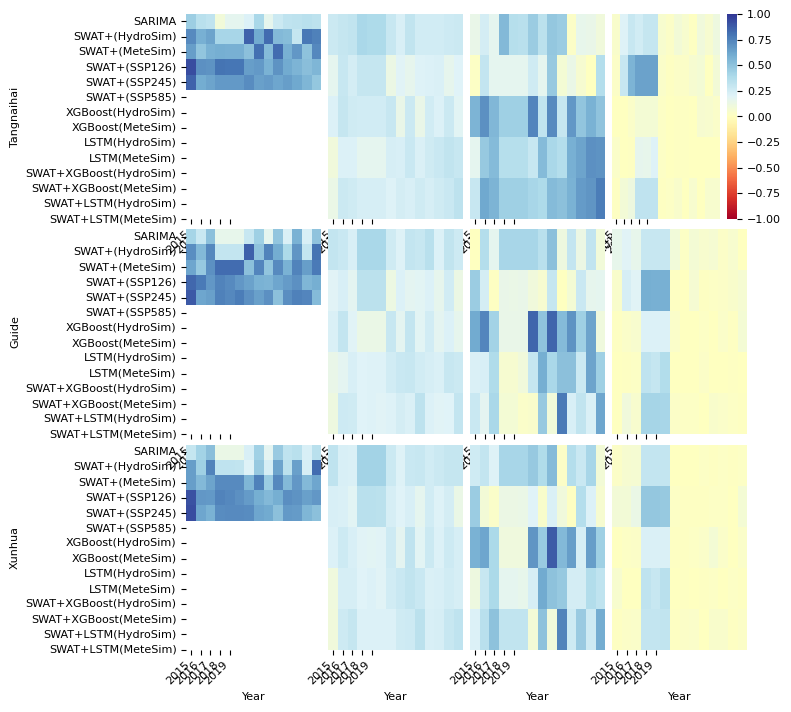

In [173]:
# Create a 3x4 subplot layout for the three stations and four metrics
fig, axes = plt.subplots(3, 4, figsize=(7.48, 7.48))

# Define metrics and their corresponding dictionaries
metrics = ['NNSE', 'NRMSE', 'PPTS', 'LPTS']
metric_dicts = [nnse_years_metrics_dict, znrmse_years_metrics_dict, ppts_years_metrics_dict, lpts_years_metrics_dict]

# Create one common colorbar for all heatmaps
norm = plt.Normalize(vmin=-1, vmax=1)  # Adjust vmin and vmax based on your data range
cmap = 'RdYlBu'  # You can change the colormap as needed

for i, hydro_station in enumerate(hydro_stations):
    for j, (metric, metric_dict) in enumerate(zip(metrics, metric_dicts)):
        ax = axes[i, j]
        
        # Get data for current station and metric
        data = metric_dict[hydro_station]
        # Check for non-numeric values in the data
        non_numeric_mask = pd.isna(pd.to_numeric(data.values.ravel(), errors='coerce')).reshape(data.shape)
        if non_numeric_mask.any():
            print(f"\nNon-numeric values found in {hydro_station} - {metric}:")
            for i, row in enumerate(data.index):
                for j, col in enumerate(data.columns):
                    if non_numeric_mask[i,j]:
                        print(f"Row: {row}, Column: {col}, Value: {data.iloc[i,j]}")

        print(data)
        
        # Convert data to numeric values
        data_numeric = data.astype(float)
        
        # Create heatmap
        sns.heatmap(data_numeric, 
                   cmap=cmap,
                   norm=norm,
                   ax=ax,
                   cbar=True if (i == 0 and j == 3) else False,  # Only show colorbar for top-right plot
                   xticklabels=data.index,
                   yticklabels=data.columns if j == 0 else False,  # Only show model names for leftmost plots
                   cbar_kws={'label': ''} if (i == 0 and j == 3) else None)
        
        # Customize axis labels and ticks
        ax.set_xlabel('') if i < 2 else ax.set_xlabel('Year')
        ax.set_ylabel('') if j > 0 else ax.set_ylabel(hydro_station)
        
        # Rotate x-axis labels
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        # Rotate y-axis labels
        if j == 0:
            plt.setp(ax.get_yticklabels(), rotation=0)

# Adjust layout
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.1, top=0.95, wspace=0.05, hspace=0.05)

# Save figures
plt.savefig('../figs/MultiModelsForecasts_Metrics_Heatmap.png', dpi=300, bbox_inches='tight')
plt.savefig('../figs/MultiModelsForecasts_Metrics_Heatmap.tif', format='tif', dpi=500, bbox_inches='tight')
plt.show()

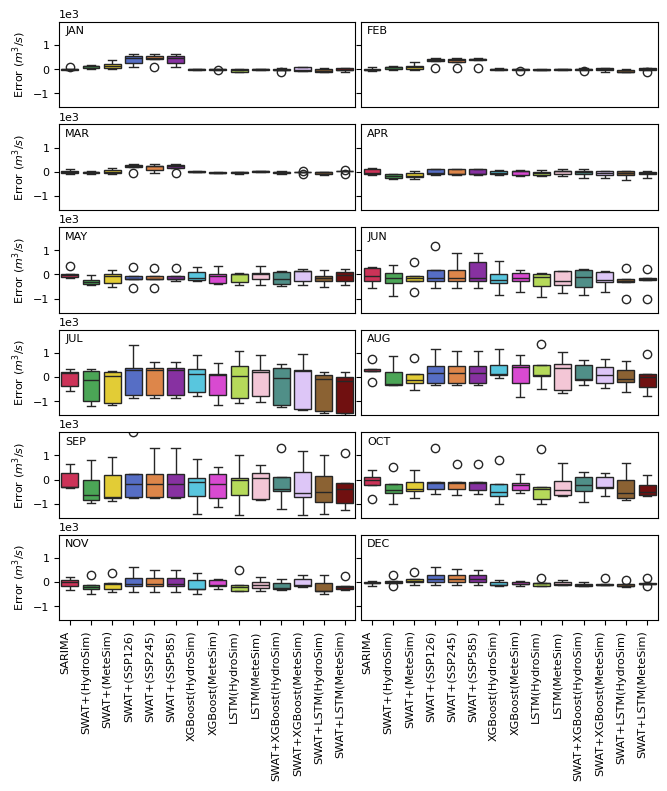

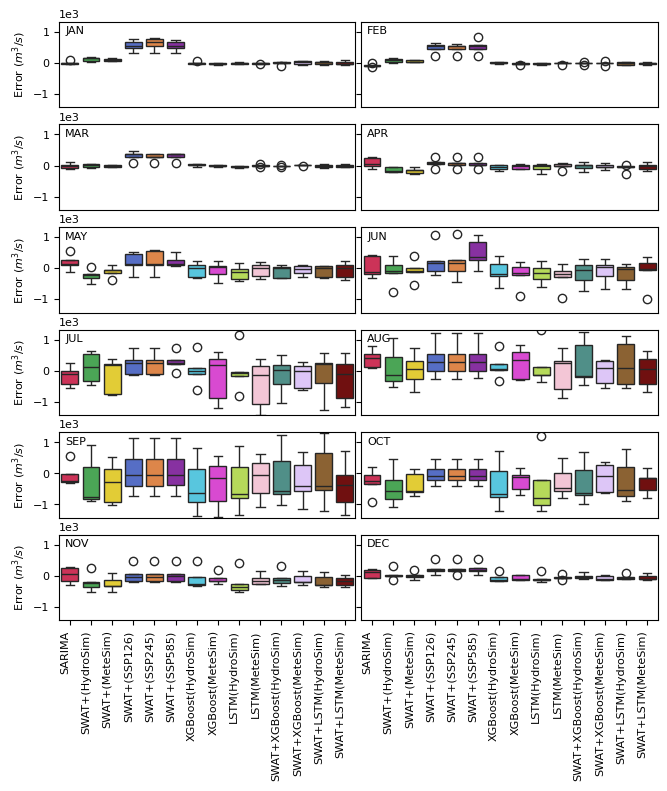

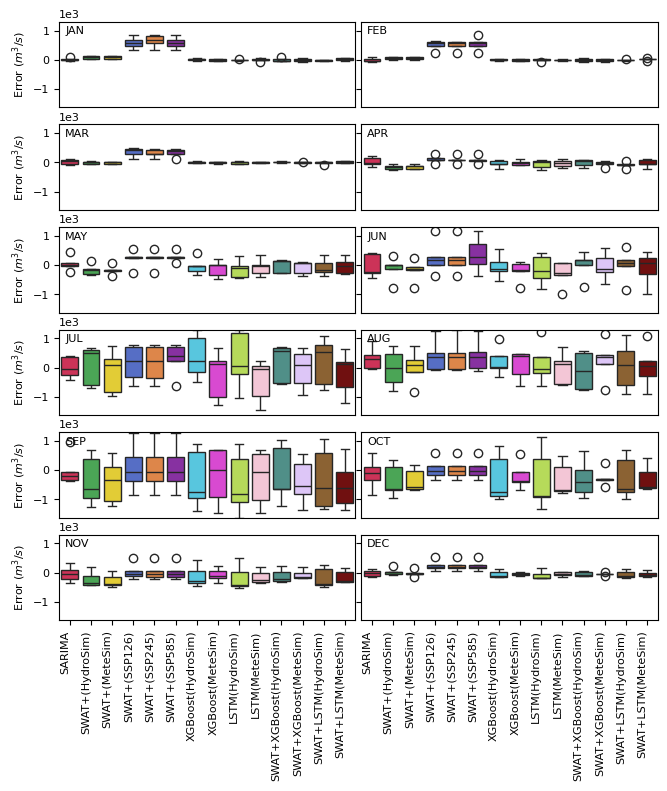

In [36]:
months_abbreviation = {
    0: 'JAN',
    1: 'FEB', 
    2: 'MAR',
    3: 'APR',
    4: 'MAY',
    5: 'JUN',
    6: 'JUL',
    7: 'AUG',
    8: 'SEP',
    9: 'OCT',
    10: 'NOV',
    11: 'DEC'
}
for hydro_station in hydro_stations:
    fig, axes = plt.subplots(6, 2, figsize=(7.48, 7.48))
    axes = axes.flatten()

    # Define distinct colors for 15 models
    colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', 
              '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff',
              '#9A6324', '#800000', 
            #   '#808000'
    ]

    model_errors_df = model_errors[hydro_station]

    # Group errors by month for each model
    monthly_errors = {}
    for model in models:
        monthly_errors[model] = [[] for _ in range(12)]
        for idx, error in model_errors_df[model].items():
            month = idx.month - 1  # Convert to 0-based index
            monthly_errors[model][month].append(error)

    # Find global min and max across all months and models
    global_min = float('inf')
    global_max = float('-inf')
    for month in range(12):
        for model in models:
            errors = monthly_errors[model][month]
            global_min = min(global_min, min(errors))
            global_max = max(global_max, max(errors))

    # Create box plots for each month
    for month in range(12):
        ax = axes[month]
        error_data = []
        for model in models:
            error_data.append(monthly_errors[model][month])

        # Create boxplot with custom colors
        bp = sns.boxplot(data=error_data, ax=ax, whis=1.5, palette=colors)
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        # Set consistent y-axis limits for all subplots
        ax.set_ylim(global_min, global_max)

        # Only show x-axis ticks and labels for last row
        if month < 10:  # Not in last row
            ax.set_xticks([])
        else:  # Last row
            ax.set_xticks(range(len(models)))
            ax.set_xticklabels(models, rotation=90, ha='right')

        # Only show y-axis labels for first column
        if month % 2 != 0:  # Not in first column
            ax.set_yticklabels([])
            ax.set_ylabel('')
        else:  # First column
            ax.set_ylabel('Error ($m^3/s$)')

        # ax.grid(True)
        ax.text(0.02, 0.95, months_abbreviation[month], transform=ax.transAxes, fontsize=8, va='top')

    plt.subplots_adjust(left=0.15,right=0.95,bottom=0.15,top=0.95,hspace=0.2,wspace=0.02)
    plt.savefig(f'../figs/MultiModelsForecastsError_{hydro_station}.png',dpi=300)
    plt.savefig(f'../figs/MultiModelsForecastsError_{hydro_station}.tif',format='tif',dpi=500,bbox_inches='tight')
    plt.show()


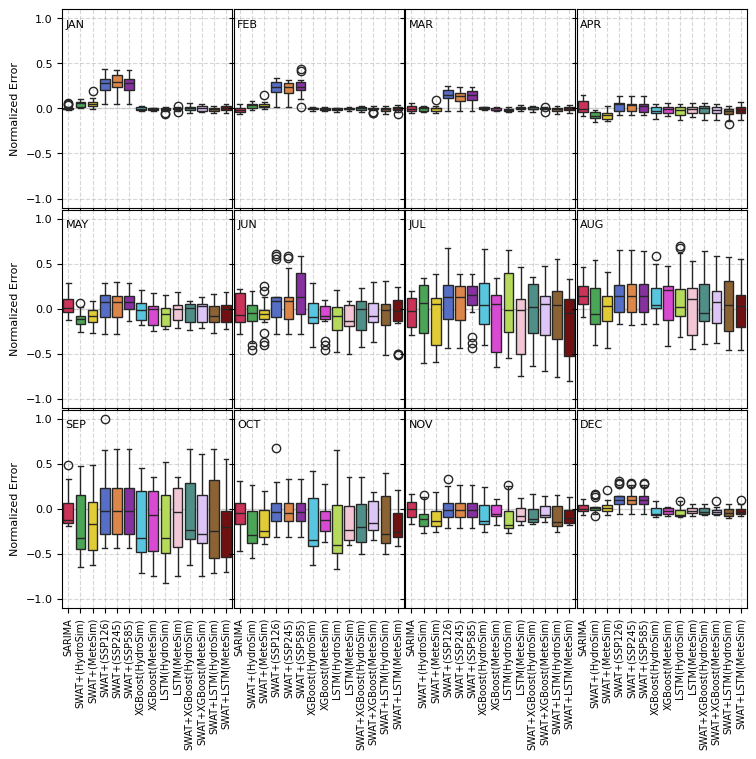

In [108]:
months_abbreviation = {
    0: 'JAN', 1: 'FEB', 2: 'MAR', 3: 'APR', 4: 'MAY', 5: 'JUN',
    6: 'JUL', 7: 'AUG', 8: 'SEP', 9: 'OCT', 10: 'NOV', 11: 'DEC'
}

# Create figure with 12 subplots (one for each month)
fig, axes = plt.subplots(3, 4, figsize=(7.48, 7.48))
axes = axes.flatten()

# Define distinct colors for 14 models (remove extra color)
colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', 
          '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff',
          '#9A6324', '#800000']

# Group errors by month and model across all stations
monthly_errors = {}
all_errors = []  # Store all errors for global normalization
for model in models:
    monthly_errors[model] = [[] for _ in range(12)]
    for station in hydro_stations:
        model_errors_df = model_errors[station]
        for idx, error in model_errors_df[model].items():
            month = idx.month - 1  # Convert to 0-based index
            monthly_errors[model][month].append(error)
            all_errors.append(error)

# Find global max and min for normalization
max_abs_error = max(abs(max(all_errors)), abs(min(all_errors)))

# Normalize errors to [-1, 1] range using global max/min
normalized_monthly_errors = {}
for model in models:
    normalized_monthly_errors[model] = [[] for _ in range(12)]
    for month in range(12):
        errors = monthly_errors[model][month]
        if errors and max_abs_error != 0:
            normalized = [e/max_abs_error for e in errors]
            normalized_monthly_errors[model][month] = normalized
        else:
            normalized_monthly_errors[model][month] = errors

# Create box plots for each month
for month in range(12):
    ax = axes[month]
    error_data = []
    for model in models:
        error_data.append(normalized_monthly_errors[model][month])

    # Create boxplot with custom colors
    bp = sns.boxplot(data=error_data, ax=ax, whis=1.5, palette=colors)
    # bp = sns.violinplot(data=error_data, ax=ax, palette=colors)
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='lightgray', alpha=0.7, zorder=1)
    
    # Set y-axis limits to [-1, 1]
    ax.set_ylim(-1.1, 1.1)

    # Only show x-axis ticks and labels for last row
    if month < 8:  # Not in last row
        # ax.set_xticks([])
        ax.set_xticklabels([])
    else:  # Last row
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, rotation=90, ha='center',fontsize=7)

    # Only show y-axis labels for first column
    if month % 4 != 0:  # Not in first column
        ax.set_yticklabels([])
        ax.set_ylabel('')
    else:  # First column
        ax.set_ylabel('Normalized Error')

    ax.text(0.02, 0.95, months_abbreviation[month], transform=ax.transAxes, fontsize=8, va='top')
    ax.grid(True, linestyle='--', alpha=0.5)  # Add grid lines to each subplot

plt.subplots_adjust(left=0.075,right=0.99,bottom=0.19,top=0.99,hspace=0.01,wspace=0.01)
plt.savefig(f'../figs/MultiModelsForecastsNormalizedError_AllStations.png',dpi=300)
plt.savefig(f'../figs/MultiModelsForecastsNormalizedError_AllStations.tif',format='tif',dpi=500)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


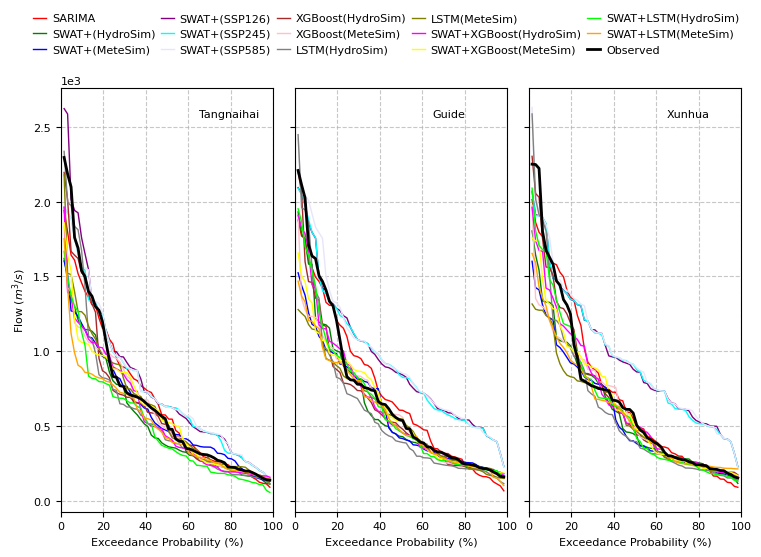

In [128]:
# Calculate exceedance probabilities and plot curves
fig, axes = plt.subplots(1, 3, figsize=(7.48, 5.5), sharey=True)

# Define distinct colors for models using a colormap
colors = plt.cm.tab20(np.linspace(0, 1, len(models)))  # Use tab20 colormap for distinct colors
colors = [
    'red',#"#FF0000",
    'green',#"#008000", 
    'blue',#"#0000FF",
    'purple',#"#800080",
    'cyan',#"#00FFFF",
    'lavender',#"#E6E6FA",
    'brown',#"#A52A2A",
    'pink',#"#FFC0CB",
    'gray',#"#808080",
    'olive',#"#808000",
    'magenta',#"#FF00FF",
    'yellow',#"#FFFF00",
    'lime',#"#00FF00",
    'orange',#"#FFA500",
    'teal',#"#008080",
]

for i, hydro_station in enumerate(hydro_stations):
    ax = axes[i]
    model_results_df = model_results[hydro_station]
    
    # First plot all model curves with distinct colors
    for idx, model in enumerate(models):
        data = model_results_df[model].sort_values(ascending=False)
        ranks = np.arange(1., len(data) + 1.)
        probs = ranks / (len(data) + 1)
        ax.plot(probs * 100, data, '-', linewidth=1, label=model, color=colors[idx])
    
    # Then plot observed curve on top
    data = model_results_df['obs'].sort_values(ascending=False)
    ranks = np.arange(1., len(data) + 1.)
    probs = ranks / (len(data) + 1)
    ax.plot(probs * 100, data, 'k-', linewidth=2, label='Observed', zorder=10)
    
    # Customize plot
    if i == 0:  # Only show y label for first subplot
        ax.set_ylabel('Flow ($m^3/s$)')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.text(0.65, 0.95, hydro_station, transform=ax.transAxes, fontsize=8, va='top')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xlabel('Exceedance Probability (%)')
    ax.set_xlim(0, 100)
    
    # Only show legend for first subplot
    if i == 1:
        ax.legend(bbox_to_anchor=(0.43, 1.2), loc='upper center', ncol=5, frameon=False,fontsize=8,handlelength=1.2,handletextpad=0.5,columnspacing=0.5)
    
    # #! Add two inset axes for detailed views
    # # Inset for high flow (low exceedance probability)
    # axins1 = ax.inset_axes([0.25, 0.6, 0.3, 0.3])
    # for idx, model in enumerate(models):
    #     data = model_results_df[model].sort_values(ascending=False)
    #     ranks = np.arange(1., len(data) + 1.)
    #     probs = ranks / (len(data) + 1)
    #     axins1.plot(probs * 100, data, '-', linewidth=1, color=colors[idx])
    # data = model_results_df['obs'].sort_values(ascending=False)
    # ranks = np.arange(1., len(data) + 1.)
    # probs = ranks / (len(data) + 1)
    # axins1.plot(probs * 100, data, 'k-', linewidth=2, zorder=10)
    # axins1.set_xlim(0, 10)  # Show first 10% exceedance probability
    # axins1.set_ylim(1.2e3, 2.5e3)    
    # axins1.grid(True, linestyle='--', alpha=0.7)
    # axins1.set_xticks([0, 5, 10])
    # axins1.set_yticks([1.5e3, 2.0e3])
    # axins1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    # axins1.tick_params(axis='both', labelsize=6)  # Set tick label font size to 6
    
    # # Inset for low flow (high exceedance probability)
    # axins2 = ax.inset_axes([0.65, 0.4, 0.3, 0.3])
    # for idx, model in enumerate(models):
    #     data = model_results_df[model].sort_values(ascending=False)
    #     ranks = np.arange(1., len(data) + 1.)
    #     probs = ranks / (len(data) + 1)
    #     axins2.plot(probs * 100, data, '-', linewidth=1, color=colors[idx])
    # data = model_results_df['obs'].sort_values(ascending=False)
    # ranks = np.arange(1., len(data) + 1.)
    # probs = ranks / (len(data) + 1)
    # axins2.plot(probs * 100, data, 'k-', linewidth=2, zorder=10)
    # axins2.set_xlim(80, 100)  # Show 80-100% exceedance probability
    # axins2.set_ylim(0.1e3, 0.3e3)
    # axins2.grid(True, linestyle='--', alpha=0.7)
    # axins2.set_xticks([80, 90, 100])
    # axins2.set_yticks([0.1e3, 0.2e3])
    # axins2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    # axins2.tick_params(axis='both', labelsize=6)  # Set tick label font size to 6

plt.subplots_adjust(left=0.07,right=0.98,bottom=0.08,top=0.85,hspace=0.2,wspace=0.1)
plt.savefig(f'../figs/MultiModelsForecastsExceedanceCurve_AllStations.png',dpi=300)
plt.savefig(f'../figs/MultiModelsForecastsExceedanceCurve_AllStations.tif',format='tif',dpi=500)
plt.savefig(f'../figs/MultiModelsForecastsExceedanceCurve_AllStations.eps',format='eps',dpi=1000)
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


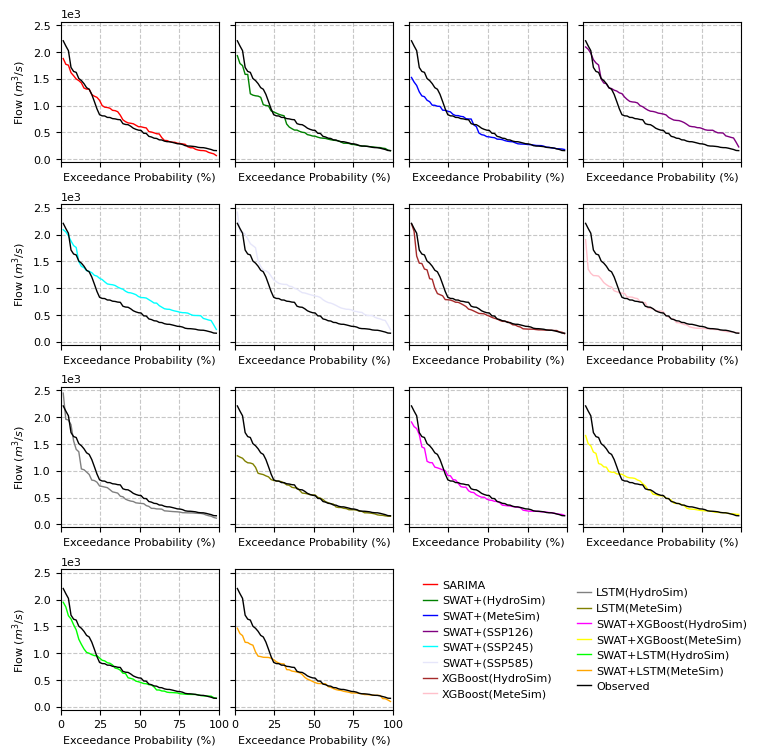

In [143]:
# Calculate exceedance probabilities and plot curves
fig, axes = plt.subplots(4, 4, figsize=(7.48, 7.48), sharex=True, sharey=True)
axes = axes.flatten()

# Define distinct colors for models using a colormap
colors = plt.cm.tab20(np.linspace(0, 1, len(models)))  # Use tab20 colormap for distinct colors
colors = [
    'red',#"#FF0000",
    'green',#"#008000", 
    'blue',#"#0000FF",
    'purple',#"#800080",
    'cyan',#"#00FFFF",
    'lavender',#"#E6E6FA",
    'brown',#"#A52A2A",
    'pink',#"#FFC0CB",
    'gray',#"#808080",
    'olive',#"#808000",
    'magenta',#"#FF00FF",
    'yellow',#"#FFFF00",
    'lime',#"#00FF00",
    'orange',#"#FFA500",
    'teal',#"#008080",
]

# Get data for Guide station
model_results_df = model_results['Guide']

# Plot each model's prediction with observed data in separate subplots
for idx, model in enumerate(models):
    if idx < 14:  # Only plot in first 14 subplots
        ax = axes[idx]
        
        # Plot model prediction
        data = model_results_df[model].sort_values(ascending=False)
        ranks = np.arange(1., len(data) + 1.)
        probs = ranks / (len(data) + 1)
        ax.plot(probs * 100, data, '-', linewidth=1, color=colors[idx])
        
        # Plot observed data
        data = model_results_df['obs'].sort_values(ascending=False)
        ranks = np.arange(1., len(data) + 1.)
        probs = ranks / (len(data) + 1)
        ax.plot(probs * 100, data, 'k-', linewidth=1, zorder=10)
        
        # Customize plot
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax.set_xlim(0, 100)
        
        # Set labels for edge plots
        if idx % 4 == 0:  # First column
            ax.set_ylabel('Flow ($m^3/s$)')
        ax.set_xlabel('Exceedance Probability (%)')  # Add xlabel to all subplots

# Turn off the last two subplots and use them for legend
axes[-1].axis('off')
axes[-2].axis('off')

# Create ordered legend items
legend_items = []
for idx, model in enumerate(models):
    legend_items.append((model, colors[idx]))
legend_items.append(('Observed', 'black'))

# Split legend into two columns across last two subplot spaces
legend1_items = legend_items[:8]
legend2_items = legend_items[8:]

# Add first column of legend to second-to-last subplot
for model, color in legend1_items:
    if model == 'Observed':
        axes[-2].plot([], [], 'k-', linewidth=1, label=model)
    else:
        axes[-2].plot([], [], '-', color=color, linewidth=1, label=model)
axes[-2].legend(loc='center', ncol=1, frameon=False, fontsize=8,
                handlelength=1.2, handletextpad=0.5)

# Add second column of legend to last subplot
for model, color in legend2_items:
    if model == 'Observed':
        axes[-1].plot([], [], 'k-', linewidth=1, label=model)
    else:
        axes[-1].plot([], [], '-', color=color, linewidth=1, label=model)
axes[-1].legend(loc='center', ncol=1, frameon=False, fontsize=8,
                handlelength=1.2, handletextpad=0.5)

plt.subplots_adjust(left=0.07,right=0.98,bottom=0.06,top=0.98,hspace=0.3,wspace=0.1)
plt.savefig(f'../figs/MultiModelsForecastsExceedanceCurve_Guide.png',dpi=300)
plt.savefig(f'../figs/MultiModelsForecastsExceedanceCurve_Guide.tif',format='tif',dpi=500)
plt.savefig(f'../figs/MultiModelsForecastsExceedanceCurve_Guide.eps',format='eps',dpi=1000)
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


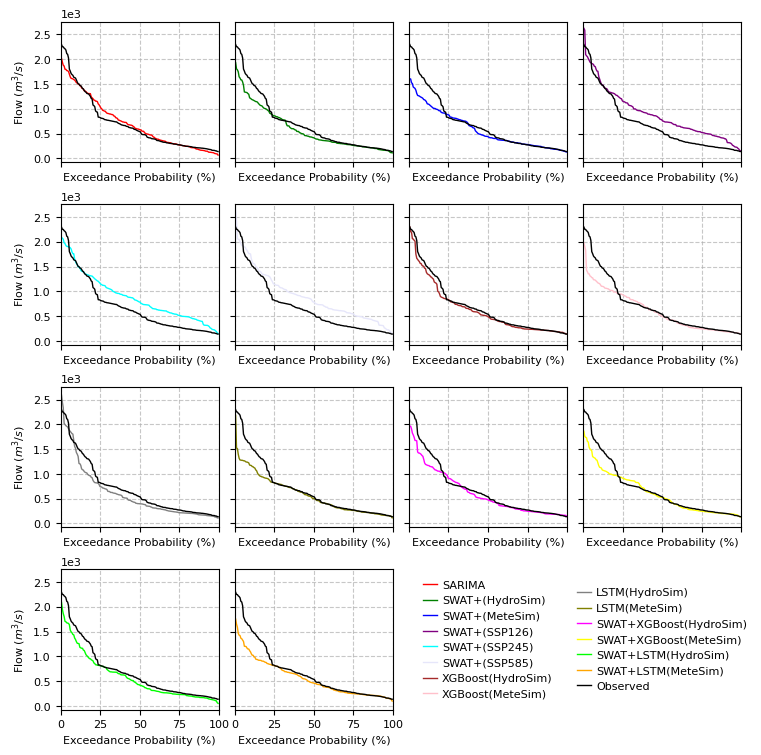

In [144]:
# Calculate exceedance probabilities and plot curves for all stations combined
fig, axes = plt.subplots(4, 4, figsize=(7.48, 7.48), sharex=True, sharey=True)
axes = axes.flatten()

# Define distinct colors for models using a colormap
colors = [
    'red',
    'green', 
    'blue',
    'purple',
    'cyan',
    'lavender',
    'brown',
    'pink',
    'gray',
    'olive',
    'magenta',
    'yellow',
    'lime',
    'orange',
    'teal',
]

# Combine data from all stations
combined_results = pd.DataFrame()
for station in hydro_stations:
    station_data = model_results[station]
    if combined_results.empty:
        combined_results = station_data
    else:
        combined_results = pd.concat([combined_results, station_data])

# Plot each model's prediction with observed data in separate subplots
for idx, model in enumerate(models):
    if idx < 14:  # Only plot in first 14 subplots
        ax = axes[idx]
        
        # Plot model prediction
        data = combined_results[model].sort_values(ascending=False)
        ranks = np.arange(1., len(data) + 1.)
        probs = ranks / (len(data) + 1)
        ax.plot(probs * 100, data, '-', linewidth=1, color=colors[idx])
        
        # Plot observed data
        data = combined_results['obs'].sort_values(ascending=False)
        ranks = np.arange(1., len(data) + 1.)
        probs = ranks / (len(data) + 1)
        ax.plot(probs * 100, data, 'k-', linewidth=1, zorder=10)
        
        # Customize plot
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax.set_xlim(0, 100)
        
        # Set labels for edge plots
        if idx % 4 == 0:  # First column
            ax.set_ylabel('Flow ($m^3/s$)')
        ax.set_xlabel('Exceedance Probability (%)')  # Add xlabel to all subplots

# Turn off the last two subplots and use them for legend
axes[-1].axis('off')
axes[-2].axis('off')

# Create ordered legend items
legend_items = []
for idx, model in enumerate(models):
    legend_items.append((model, colors[idx]))
legend_items.append(('Observed', 'black'))

# Split legend into two columns across last two subplot spaces
legend1_items = legend_items[:8]
legend2_items = legend_items[8:]

# Add first column of legend to second-to-last subplot
for model, color in legend1_items:
    if model == 'Observed':
        axes[-2].plot([], [], 'k-', linewidth=1, label=model)
    else:
        axes[-2].plot([], [], '-', color=color, linewidth=1, label=model)
axes[-2].legend(loc='center', ncol=1, frameon=False, fontsize=8,
                handlelength=1.2, handletextpad=0.5)

# Add second column of legend to last subplot
for model, color in legend2_items:
    if model == 'Observed':
        axes[-1].plot([], [], 'k-', linewidth=1, label=model)
    else:
        axes[-1].plot([], [], '-', color=color, linewidth=1, label=model)
axes[-1].legend(loc='center', ncol=1, frameon=False, fontsize=8,
                handlelength=1.2, handletextpad=0.5)

plt.subplots_adjust(left=0.07,right=0.98,bottom=0.06,top=0.98,hspace=0.3,wspace=0.1)
plt.savefig(f'../figs/MultiModelsForecastsExceedanceCurve_Combined.png',dpi=300)
plt.savefig(f'../figs/MultiModelsForecastsExceedanceCurve_Combined.tif',format='tif',dpi=500)
plt.savefig(f'../figs/MultiModelsForecastsExceedanceCurve_Combined.eps',format='eps',dpi=1000)
plt.show()


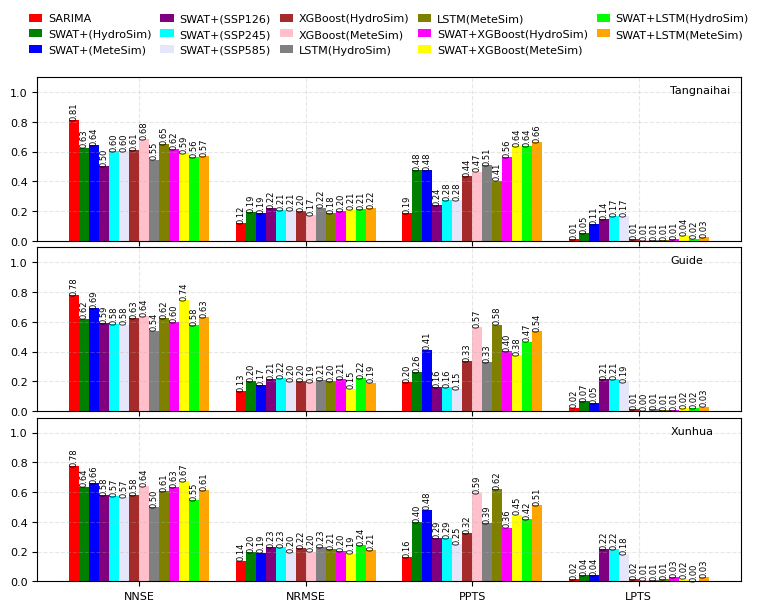

In [41]:
fig, axes = plt.subplots(3, 1, figsize=(7.48, 6), sharex=True)

metrics = ['NNSE', 'NRMSE', 'PPTS', 'LPTS']
bar_width = 0.06
n_models = len(models)

# Calculate x positions for bars
x = np.arange(len(metrics))

for i, hydro_station in enumerate(hydro_stations):
    ax = axes[i]
    
    # Plot bars for each model
    for j, model in enumerate(models):
        values = metrics_dict[hydro_station].loc[model]
        bars = ax.bar(x + j*bar_width, values, 
                     bar_width, label=model, color=colors[j])
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar_width/2, height,
                   f'{height:.2f}',
                   ha='center', va='bottom', rotation=90,
                   fontsize=6)
    
    # Customize plot
    ax.set_ylim(0, 1.1)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.text(0.9, 0.95, hydro_station, transform=ax.transAxes,
            fontsize=8, va='top')

    # ax.set_ylabel('Flow($m^3/s$)/Flow($m^3/s$)')
    
    # Only show legend for first subplot
    if i == 0:
        ax.legend(bbox_to_anchor=(0.5, 1.45), loc='upper center',
                 ncol=5, frameon=False, fontsize=8,
                 handlelength=1.2, handletextpad=0.5,columnspacing=0.8)
    
    # Only show x-axis labels for last subplot
    if i == 2:
        ax.set_xticks(x + bar_width * (n_models/2 - 0.5))
        ax.set_xticklabels(metrics)
    else:
        ax.set_xticks([])
    
    # Show y-axis label for all subplots
    # ax.set_ylabel('Value')

plt.subplots_adjust(left=0.05, right=0.99, bottom=0.04, top=0.88, hspace=0.04)
plt.savefig('../figs/MultiModelsForecastsMetrics_AllStations.png',dpi=300)
plt.savefig('../figs/MultiModelsForecastsMetrics_AllStations.tif',format='tif', dpi=500)
plt.show()


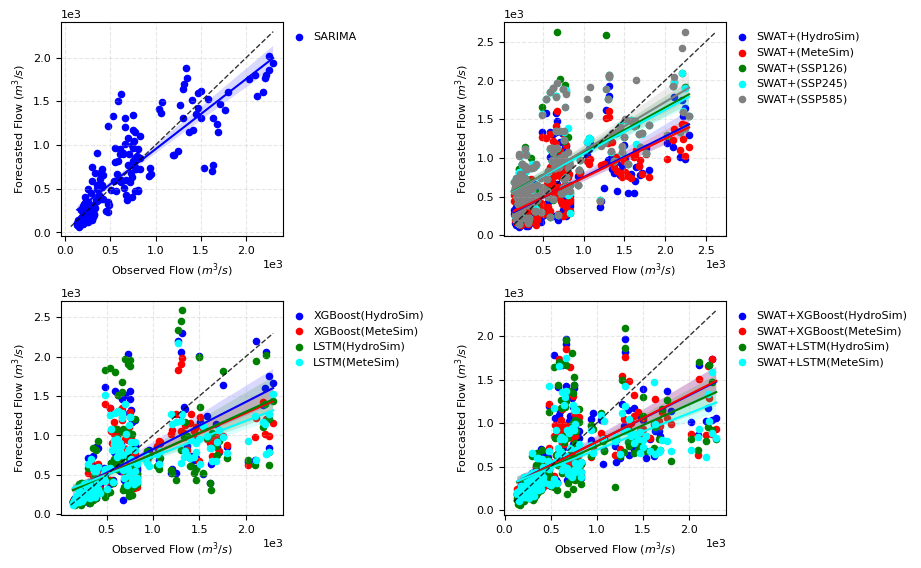

In [75]:
# Group models by type
model_groups = {
    'Auto-regressive': ['SARIMA'],
    'Process-driven': ['SWAT+(HydroSim)', 'SWAT+(MeteSim)', 'SWAT+(SSP126)', 'SWAT+(SSP245)', 'SWAT+(SSP585)'],
    'Data-driven': ['XGBoost(HydroSim)', 'XGBoost(MeteSim)', 'LSTM(HydroSim)', 'LSTM(MeteSim)'],
    'Hybrid': ['SWAT+XGBoost(HydroSim)', 'SWAT+XGBoost(MeteSim)', 'SWAT+LSTM(HydroSim)', 'SWAT+LSTM(MeteSim)']
}

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(7.48, 5.48))
axes = axes.flatten()

# Define colors for different models
model_colors = {
    'SARIMA': 'blue',
    'SWAT+(HydroSim)': 'blue',
    'SWAT+(MeteSim)': 'red', 
    'SWAT+(SSP126)': 'green',
    'SWAT+(SSP245)': 'cyan',
    'SWAT+(SSP585)': 'gray',
    'XGBoost(HydroSim)': 'blue',
    'XGBoost(MeteSim)': 'red',
    'LSTM(HydroSim)': 'green',
    'LSTM(MeteSim)': 'cyan',
    'SWAT+XGBoost(HydroSim)': 'blue',
    'SWAT+XGBoost(MeteSim)': 'red',
    'SWAT+LSTM(HydroSim)': 'green',
    'SWAT+LSTM(MeteSim)': 'cyan'
}

# Create scatter plots for each model group
for idx, (group_name, group_models) in enumerate(model_groups.items()):
    ax = axes[idx]
    
    # Plot each model separately
    for model in group_models:
        all_obs = []
        all_pred = []
        
        # Collect data from all stations for this model
        for station in hydro_stations:
            model_results_df = model_results[station]
            obs = model_results_df['obs']
            pred = model_results_df[model]
            all_obs.extend(obs)
            all_pred.extend(pred)
            
        # Create scatter plot using seaborn
        sns.regplot(x=all_obs, y=all_pred, 
                   scatter_kws={'color': model_colors[model], 'alpha': 1, 's': 20},
                   line_kws={'color': model_colors[model], 'alpha': 1},
                   label=model, ax=ax)
    
    # Add 1:1 line
    max_val = max(max(all_obs), max(all_pred))
    min_val = min(min(all_obs), min(all_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8)
    
    # Calculate R² for all data
    r2 = r2_score(all_obs, all_pred)
    
    # Customize plot
    ax.set_xlabel('Observed Flow ($m^3/s$)')
    ax.set_ylabel('Forecasted Flow ($m^3/s$)')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Show legend for each subplot on the right side
    ax.legend(bbox_to_anchor=(1.0, 1), loc='upper left',
             ncol=1, frameon=False, fontsize=8, handlelength=1)

plt.subplots_adjust(left=0.06, right=0.95, bottom=0.08, top=0.98, hspace=0.3, wspace=0.99)
plt.savefig('../figs/MultiModelsForecastsScatter_ByModelType.png', dpi=300, bbox_inches='tight')
plt.savefig('../figs/MultiModelsForecastsScatter_ByModelType.tif', format='tif', dpi=500, bbox_inches='tight')
plt.show()